# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np

In [2]:
def save_and_show_plot(fig, filename, directory='plots_folder'):
    # Make sure the directory exists, if not, create it
    os.makedirs(directory, exist_ok=True)
    fig.savefig(f"{directory}/{filename}.png", bbox_inches='tight', dpi=300)
    plt.close(fig)  # Close the figure


In [3]:
import os

def find_latest_result_folder(path):
    result_folders = [folder for folder in os.listdir(path) if folder.startswith("Results")]
    if not result_folders:
        raise ValueError("No 'Results' folders found.")
        
    result_numbers = [int(folder.split("_")[-1]) if "_" in folder else 0 for folder in result_folders]
    latest_result = max(result_numbers)
    
    if latest_result == 0:
        return "Results"
    else:
        return f"Results_{latest_result}"

def latest_result_finder(path):
    latest_result_path = find_latest_result_folder(path)
    path = path + '/' + latest_result_path + '/'
    return(path)
    
def open_results_file(file_name, scenario):
    scenario = '/Users/lesarmstrong/Documents/GitHub/DOLPHYN_May2023_SuperCloud/Example_Systems/PJM_with_MI/' + scenario
    path = latest_result_finder(scenario)
    if file_name.startswith('HSC'):
        path = path + 'Results_HSC/'
    path = path + file_name
    #print(path)
    df = pd.read_csv(path)
    return(df)


In [4]:
def identify_tech_type(df, resources, aggregate=True, dont_aggregate=''):
    tech_types = []
    for name in df['Resource']:
        for zone in zones:
            if name.startswith(zone):
                cleaned_string = name[len(zone) + 1:]
                break
            else:
                cleaned_string = name
        
        for r in resources:
            if cleaned_string.startswith(r):
                result_string = resources[r]
                break
            else:
                result_string = cleaned_string
        tech_types.append(result_string)

    df['Tech_Type'] = tech_types
    
    if aggregate == True:
        # Aggregate other columns based on the identified technology types
        aggregated_df = df.groupby('Tech_Type').sum().reset_index()
        
        if dont_aggregate != '':
            aggregated_df = df.groupby(dont_aggregate).sum().reset_index()
            

        return aggregated_df
    if aggregate == False:
        return df



In [5]:
scenarios_no_caverns = ['PJM_with_MI_no_caverns_0_red',
    'PJM_with_MI_no_caverns_70_red',
    'PJM_with_MI_no_caverns_85_red',
    'PJM_with_MI_no_caverns_90_red',
    'PJM_with_MI_no_caverns_95_red',
    'PJM_with_MI_no_caverns_99_red',
    'PJM_with_MI_no_caverns_100_red']
 
scenarios_with_caverns =  ['PJM_with_MI_with_caverns_0_red',
    'PJM_with_MI_with_caverns_70_red',
    'PJM_with_MI_with_caverns_85_red',
    'PJM_with_MI_with_caverns_90_red',
    'PJM_with_MI_with_caverns_95_red',
    'PJM_with_MI_with_caverns_99_red',
    'PJM_with_MI_with_caverns_100_red']

scenario = 'PJM_with_MI_with_caverns_95_red'


zones = [
    "MIS_INKY",
    "PJM_WMAC",
    "PJM_SMAC",
    "PJM_West",
    "PJM_AP",
    "PJM_COMD",
    "PJM_ATSI",
    "PJM_Dom",
    "PJM_PENE",
    "S_C_KY",
    "PJM_EMAC",
    "MIS_LMI"
]

# Zone identifier
def zone_ID(file_name='HSC_h2_generation_discharge.csv', scenario=scenario):
    df = open_results_file(file_name='HSC_h2_generation_discharge.csv', scenario=scenario)
    df = df.T
    df = df.reset_index()
    df.columns = df.iloc[0]
    df = df[1:]
    df = df.rename(columns={'Zone': 'Zone_N'})
    df = df[df['Resource'] != 'Total']
    resources = df[df['Resource'] != 'Total']

    df = identify_tech_type(df, resources, aggregate=False)
    df = df.iloc[:-1]
    df = df.reset_index()
    df['Zone'] = df['Resource'].apply(lambda resource: next((zone for zone in zones if zone in resource), None))
    zone_dict = pd.Series(df.Zone.values,index=df.Zone_N).to_dict()
    zone_dict = {f'z{int(k)}': v for k, v in zone_dict.items()}
    return(zone_dict)


#Dictionary of zone numbers
zone_ID_dict = zone_ID(file_name='HSC_h2_generation_discharge.csv', scenario=scenario)
# Zones list
zones = list(zone_ID_dict.values())





generation_resources = [
    "conventional_hydroelectric",
    "conventional_steam_coal",
    "natural_gas_fired_combined_cycle",
    "natural_gas_fired_combustion_turbine",
    "solar_photovoltaic",
    "onshore_wind_turbine",
    "small_hydroelectric",
    "hydroelectric_pumped_storage",
    "nuclear",
    "naturalgas_ccccsavgcf_conservative",
    "naturalgas_ccavgcf_moderate",
    "naturalgas_ctavgcf_moderate",
    "landbasedwind",
    "battery",
    "utilitypv",
    "offshorewind",
    "CCGT-H2",
    "OCGT-H2",
]

# Mapping resources to categories
generation_resource_categories = {
    "conventional_hydroelectric": "Hydro",
    "conventional_steam_coal": "Coal",
    "natural_gas_fired_combined_cycle": "Existing_natural_gas",
    "natural_gas_fired_combustion_turbine": "Existing_natural_gas",
    "naturalgas_ccavgcf_moderate": "New_natural_gas",
    "naturalgas_ctavgcf_moderate": "New_natural_gas",
    "naturalgas_ccccsavgcf_conservative": "Natural_gas_with_CCS",
    "solar_photovoltaic": "Solar",
    "onshore_wind_turbine": "Wind",
    "small_hydroelectric": "Hydro",
    "hydroelectric_pumped_storage": "Hydro",
    "nuclear": "Nuclear",
    "landbasedwind": "Wind",
    "battery": "Battery",
    "utilitypv": "Solar",
    "offshorewind": "Wind",
    "CCGT-H2": "H2",
    "OCGT-H2": "H2",
}

H2_resource_categories = {
    "Electrolyzer": "Electrolyzer",
    "Large_SMR_wCCS_96pct": "Large_SMR_wCCS_96pct",
    "Large_SMR": "Large_SMR",
    "ATR_wCCS_94pct": "ATR_wCCS_94pct",
    "Salt_cavern_storage": "Salt_cavern_storage",
}


colors_generation = {
    'H2': 'skyblue', 
    'Battery': 'orange', 
    'Coal': 'black', 
    'Hydro': 'blue',
    'Existing_natural_gas': 'grey',
    'Natural_gas_with_CCS': 'lightgrey',
    'New_natural_gas': 'maroon',
    'Nuclear': 'purple',
    'Solar': '#FFD700',
    'Wind': 'green'
}


H2_colors = {
    "Electrolyzer": "#7B68EE",  # Medium Slate Blue 
    "Large_SMR_wCCS_96pct": "#808000", # Olive
    "Large_SMR": "darkgrey",  # Dark Grey
    "ATR_wCCS_94pct": "#008080",  # Teal
    "Salt_cavern_storage": "#BA55D3",  # Medium Orchid
    "Above_ground_storage": "saddlebrown"
}

costs_colors = {
    'cTotal': 'blue',
    'cFix_Thermal': 'firebrick',
    'cFix_VRE': 'orange',
    'cFix_Trans_VRE': 'gold',
    'cFix_Must_Run': 'yellowgreen',
    'cFix_Hydro': 'lightgreen',
    'cFix_Stor': 'darkgreen',
    'cVar': 'lightblue',
    'cNSE': 'dodgerblue',
    'cStart': 'navy',
    'cUnmetRsv': 'mediumpurple',
    'cNetworkExp': 'plum',
    'cH2Fix_Gen': 'violet',
    'cH2Fix_G2P': 'magenta',
    'cH2Fix_Stor': 'crimson',
    'cH2Fix_Truck': 'palevioletred',
    'cH2Var': 'pink',
    'cH2NSE': 'peachpuff',
    'cH2Start': 'sandybrown',
    'cH2NetworkExp': 'chocolate',
    'cDACFix': 'sienna',
    'cDACVar': 'maroon',
    'cCO2Comp': 'coral',
    'cCO2Start': 'tomato',
    'cCO2Stor': 'salmon',
    'cCO2NetworkExp': 'darkorange',
    'cBiorefineryFix': 'khaki',
    'cBiorefineryVar': 'yellow',
    'cHerb': 'springgreen',
    'cWood': 'mediumseagreen',
    'cSFFix': 'teal',
    'cSFVar': 'turquoise',
    'cSFByProdRev': 'cyan',
    'CSFConvDieselFuelCost': 'deepskyblue',
    'CSFConvJetfuelFuelCost': 'blue',
    'CSFConvGasolineFuelCost': 'slateblue',
    'cPower_Total': 'blueviolet',
    'cHSC_Total': 'purple',
    'cCSC_Total': 'indigo',
    'cBiorefinery': 'pink',
    'cBioresources': 'lightcoral',
    'cSF_Prod': 'lightsalmon',
    'cConv_Fuels': 'darkred',
    'cHydro_Must_Run': 'darkgrey',
}

emissions_colors = {
    "Power System": "#FF8C00",  # Medium Slate Blue 
    "H2 System": 'skyblue', # Olive
}

rename_dict= {
    'PJM_with_MI_no_caverns_0_red': 'No Emission Cap\n without Salt Caverns',
    'PJM_with_MI_no_caverns_70_red': '70% Emission Reduction Cap\n without Salt Caverns',
    'PJM_with_MI_no_caverns_85_red': '85% Emission Reduction Cap\n without Salt Caverns',
    'PJM_with_MI_no_caverns_90_red': '90% Emission Reduction Cap\n without Salt Caverns',
    'PJM_with_MI_no_caverns_95_red': '95% Emission Reduction Cap\n without Salt Caverns',
    'PJM_with_MI_no_caverns_99_red': '99% Emission Reduction Cap\n without Salt Caverns',
    'PJM_with_MI_no_caverns_100_red': '100% Emission Reduction Cap\n without Salt Caverns',
    'PJM_with_MI_with_caverns_0_red': 'No Emission Cap\n with Salt Caverns',
    'PJM_with_MI_with_caverns_70_red': '70% Emission Reduction Cap\n with Salt Caverns',
    'PJM_with_MI_with_caverns_85_red': '85% Emission Reduction Cap\n with Salt Caverns',
    'PJM_with_MI_with_caverns_90_red': '90% Emission Reduction Cap\n with Salt Caverns',
    'PJM_with_MI_with_caverns_95_red': '95% Emission Reduction Cap\n with Salt Caverns',
    'PJM_with_MI_with_caverns_99_red': '99% Emission Reduction Cap\n with Salt Caverns',
    'PJM_with_MI_with_caverns_100_red': '100% Emission Reduction Cap\n with Salt Caverns'
}



title=''
legend_title=''
y_label = '' 


scenarios = scenarios_no_caverns

In [6]:
def capacity_w_H2G2p_analysis(scenario, generation_resource_categories=generation_resource_categories):
    df = open_results_file('capacity_w_H2G2P.csv', scenario)
    aggregated_df = identify_tech_type(df, generation_resource_categories)
    return(aggregated_df)

def power_w_H2G2p_analysis(scenario, generation_resource_categories=generation_resource_categories):
    df = open_results_file('power_w_H2G2P.csv', scenario)
    df = df.T 

    # Step 1: Convert the index into a column
    df_with_index_as_column = df.reset_index()

    # Step 2: Rename the new column
    df_with_index_as_column = df_with_index_as_column.rename(columns={'index': 'your_new_column_name'})

    # Step 3: Convert the first row into column indices
    df_with_index_as_column.columns = df_with_index_as_column.iloc[0]

    # Step 4: Drop the first row
    df_with_index_as_column = df_with_index_as_column.drop(df_with_index_as_column.index[0])

    # Step 5: Reset the index
    df_with_index_as_column = df_with_index_as_column.reset_index(drop=True)
    df = df_with_index_as_column[['Resource', 'AnnualSum']]
    df = df.iloc[:-1]
    df = identify_tech_type(df, generation_resource_categories)
    return(df)

def generation_difference_analysis(scenario, generation_resource_categories=generation_resource_categories):
    df = open_results_file('capacity_w_H2G2P.csv', scenario)
    df = identify_tech_type(df, generation_resource_categories)
    df = df[['Tech_Type', 'StartCap', 'EndCap']]
    #df = df[df['Tech_Type'] != 'Total']
    df['Cap_difference'] = df['EndCap'] - df['StartCap'] 
    return(df)


def h2_capacity_analysis(scenario,H2_resource_categories=H2_resource_categories):
    #scenario = 'PJM_with_MI_no_caverns_70_red'
    df = open_results_file('HSC_generation_storage_capacity.csv', scenario)
    #aggregated_df = identify_tech_type(df, generation_resource_categories)
    aggregated_df = identify_tech_type(df, H2_resource_categories)
    return(aggregated_df)

def h2_generation_analysis(scenario,H2_resource_categories=H2_resource_categories, aggregate_zones=True):
    #scenario = 'PJM_with_MI_no_caverns_70_red'
    df = open_results_file('HSC_h2_generation_discharge.csv', scenario)
    df = df.T.reset_index()
    # assuming df is your DataFrame
    df.columns = df.iloc[0]
    df = df[1:]
    
    if aggregate_zones == True:
        aggregated_df = identify_tech_type(df, H2_resource_categories)
        return(aggregated_df)
    
    if aggregate_zones == False:
        df = df.rename(columns={'Zone': 'Zone_N'})
        df = identify_tech_type(df, resources, aggregate=False)
        df = df.iloc[:-1]
        df = df.reset_index()
        df['Zone'] = df['Resource'].apply(lambda resource: next((zone for zone in zones if zone in resource), None))
 
        return(df)
        

## GET COSTS ##
def get_total(df, cost_name):
    total = df.loc[df['Costs'] == cost_name, 'Total'].values[0]
    return total

def cost_analysis(scenario, cost_name='cTotal'):
    df = open_results_file('costs_system.csv', scenario)
    cost = get_total(df, cost_name)
    return(cost)
   
    
def max_row_sum_for_yaxis(df):
    index_of_max_sum_row = df.clip(lower=0).sum(axis=1).idxmax()
    max_sum_row = df.loc[index_of_max_sum_row].clip(lower=0).sum()
    #print(df.loc[index_of_max_sum_row].sum())
    #print(max_sum_row)
    return(max_sum_row)

def min_row_sum_for_yaxis(df):
    #print(df)
    index_of_min_sum_row = df.sum(axis=1).idxmin()
    #print(index_of_min_sum_row)
    min_sum_row = df.loc[index_of_min_sum_row].sum()
    #print(df.loc[index_of_min_sum_row].sum())
    #print(min_sum_row)
    
    min_sum_row = df.min().min()
    #print(min_sum_row)
    return(min_sum_row)

In [7]:
# Trying to write load data into plot with dotted line. Will have to add new function to stacked barchart function
# Returns yearly load data for each zone [metric tons]
def zone_h2_load_data(load_file = '../HSC_load_data.csv', scenario=scenario):

    df = open_results_file(file_name=load_file, scenario=scenario)

    zone_dict = zone_ID()

    # Create a list of all columns in df that contain 'zn' in their names
    zn_columns = [col for col in df.columns if 'z' in col]

    # Create a new dictionary with the zone names from zone_dict as keys and the corresponding column values from df as values
    # Multiplied by 8760 to go from tons/hr ---> tons/year
    new_dict = {zone_dict[key.replace("Load_H2_tonne_per_hr_", "")]: int(df[key].values[0]*8760) for key in zn_columns}

    # Print the new dictionary
    return(new_dict)


def power_load_data(load_file = 'power_w_H2G2P.csv', scenario=scenario):
    df = open_results_file(file_name=load_file, scenario=scenario)
    df = df.T
    df.columns = df.iloc[0] 
    df = df.iloc[1:]

    df = df.reset_index()
    df = df.rename(columns={'index': 'Resource'})
    df = identify_tech_type(df, generation_resource_categories, aggregate=True, dont_aggregate=['Zone'])
    df = df.iloc[1:]
    #df = df[['Zone', 'Resource', 'AnnualSum']]
    return(df)

power_load_data(load_file = 'power_w_H2G2P.csv', scenario=scenario)

def HSC_h2_balance_dict(file_name='Results_HSC/HSC_h2_balance.csv', scenario=scenario):
    df = open_results_file(file_name=file_name, scenario=scenario)
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df = df.rename(columns={'Zone': 'Zone_N'})

    df['Zone_N'] = 'z' + df['Zone_N'].astype(int).astype(str)
    df['Zone'] = df['Zone_N'].map(zone_ID_dict)

    df = df[['Zone', 'AnnualSum']]
    df.index = df.index.str.split('.').str[0]

    keywords = ['Generation', 'H2_Pipeline_Import/Export', 'H2G2P', 'Demand']
    df = df[df.index.isin(keywords)]

    # Create a pivot table where each zone's data forms a sub-DataFrame
    df_pivot = df.pivot(columns='Zone', values='AnnualSum')

    # Simplify the DataFrame removing unnecessary multi-indexing
    df_pivot.columns.name = None
    df_pivot.index.name = None
    df = df_pivot.T
    return df


df_HSC_h2_balance = HSC_h2_balance_dict()

df_HSC_h2_balance

,Demand,Generation,H2G2P,H2_Pipeline_Import/Export
MIS_INKY,-507204.0,593209.753235,-28.596049,-85977.157169
MIS_LMI,-168454.8,235163.944534,-99166.00069,32456.856173
PJM_AP,-130129.8,123480.848997,-15.697588,6664.648607
PJM_ATSI,-227322.0,199391.970455,-17.816767,27947.846328
PJM_COMD,-138473.7,134497.387392,-30.995465,4007.308089
PJM_Dom,-45880.5,45104.63021,-24.492116,800.361923
PJM_EMAC,-50545.2,51518.885562,-17.012791,-956.672755
PJM_PENE,-38368.8,39877.55613,-15.810685,-1492.945429
PJM_SMAC,-46778.4,48528.866391,-35.87995,-1714.586426
PJM_WMAC,-38368.8,38718.027141,-22.783012,-326.444113


In [8]:
def multiple_zone_barchart_plot(dataframes_dict, scenarios=scenarios, zones=zones):

    # Finds max value which allows me to set scale for all the barplots relative to each other

    max_value = 0

    for keys, df in dataframes_dict.items():
        filtered_df = df[~df['Tech_Type'].str.contains('storage')]
        max_in_df = filtered_df['AnnualSum'].max()

        if max_in_df > max_value:
            max_value = max_in_df
    
    # Find load data for each zone
    h2_load_zoned = zone_h2_load_data()
    
    for zone in zones:

        df_main = pd.DataFrame()

        for scenario in scenarios:
            dff = dataframes_dict[(zone,scenario)]

            dff = dff[['Tech_Type', 'AnnualSum']]
            #dff = dff.set_index('Tech_Type')


            dff = dff.rename(columns={'AnnualSum': scenario})#

            dff = dff[dff['Tech_Type'] != 'Above_ground_storage']
            dff = dff[dff['Tech_Type'] != 'Salt_cavern_storage']

            # Transpose the dataframe    
            dff = dff.set_index('Tech_Type').T
            #dff = dff.columns = dff.columns.droplevel(0)
            #dff = dff.set_index('Tech_Type', inplace=True)
            #

            #dff.reset_index()
            df_main = df_main.append(dff, ignore_index=False)

        plot_stacked_barchart(df_main=df_main, title=zone, legend_title="", y_label="", units=2,
                              retirement=False, sort_values=False, legend_custom=False, comparing=False,
                               spatial_shared_y_limit=max_value, load_data=h2_load_zoned[zone])


    #df_main


In [9]:
def h2_generation(scenarios=scenarios, title=title, y_label=y_label, units=2):
    df_main = pd.DataFrame()
    
    for scenario in scenarios:
        df = h2_generation_analysis(scenario,H2_resource_categories=H2_resource_categories)


        df = df[['Tech_Type', 'AnnualSum']]
        df = df[df['Tech_Type'] != 'Total']
        df = df.rename(columns={'AnnualSum': scenario})#

        df = df[df['Tech_Type'] != 'Above_ground_storage']
        df = df[df['Tech_Type'] != 'Salt_cavern_storage']

        # Transpose the dataframe    
        df = df.set_index('Tech_Type').T
        #df.plot(kind='bar', stacked=True, label=scenario)
        
        df_main = df_main.append(df, ignore_index=False)
    print(df_main)
    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)

# Plotting Stacked Barcharts

In [10]:
title=''
legend_title=''
y_label = '' 

def plot_stacked_barchart(df_main, title=title, legend_title=legend_title, y_label=y_label, units=1,
                          retirement=False, sort_values=False, legend_custom=False, comparing=False,
                          spatial_shared_y_limit=0, load_data=0):
    
    #print(df_main)
    #print("UNITS ARE: " + str(units))
    H2_colors = {
        "Electrolyzer": "#7B68EE",  # Medium Slate Blue 
        "Large_SMR_wCCS_96pct": "#808000", # Olive
        "Large_SMR": "darkgrey",  # Dark Grey
        "ATR_wCCS_94pct": "#008080",  # Teal
        "Salt_cavern_storage": "#BA55D3",  # Medium Orchid
        "Above_ground_storage": "saddlebrown"
    }

    # units = 1 is for generation
    if units == 1:
        # MW --> GW
        df_main = df_main.div(1000)
        colors = colors_generation
   
    # units = 2 is for H2
    if units == 2:
        colors = H2_colors
    
    # units = 3 is for Costs
    if units == 3:
        colors = costs_colors
    
    # All others? (For now is for emissions)
    if units == 4:
        colors = emissions_colors


    if sort_values == True:
        # Calculate the sum of each row (i.e., the total height of each bar)
        row_sums = df_main.sum(axis=1)

        # Sort the DataFrame by the row sums
        df_main = df_main.loc[row_sums.sort_values().index]

        
    # Create a new figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))


    # With retirement
    #if retirement == True:
    if df_main.select_dtypes(include=[np.number]).min().min() < -1:
        # Split the dataframe into two: one for positive values and another for negative values
        df_pos = df_main.clip(lower=0)  # This replaces negative values with 0
        df_neg = df_main.clip(upper=0)  # This replaces positive values with 0

        # Create the bar chart for positive values
        ax = df_pos.plot(kind='bar', stacked=True, color=[colors[i] for i in df_pos.columns], ax=ax)

        # Stack the negative values below by creating a bar chart with negative dataframe
        ax = df_neg.plot(kind='bar', stacked=True, color=[colors[i] for i in df_neg.columns], ax=ax)

    else:
        #print(colors)
        ax = df_main.plot(kind='bar', stacked=True, color=[colors[i] for i in df_main.columns], ax=ax)
        
        
    df_main.rename(index=rename_dict, inplace=True)
   # Create a custom legend
    handles, labels = ax.get_legend_handles_labels()
    # Create a dictionary to eliminate duplicate entries
    legend_dict = dict(zip(labels, handles))
    ax.legend(legend_dict.values(), legend_dict.keys(), title=legend_title)

    # Set the y-axis label
    ax.set_ylabel(y_label)
    # Add grid lines
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', which='major', color='gray', alpha=.3, axis='y')

    # Adjust y-axis limits
    max_value = max_row_sum_for_yaxis(df_main)
    
    ## If plotting multiple barcharts that all share scale (so for for example a spatial analysis) ##
    if spatial_shared_y_limit != 0:
        max_value = spatial_shared_y_limit
    
    max_limit = max_value * 1.1
    
    min_value = min_row_sum_for_yaxis(df_main)
    min_limit = min_value * 2 if min_value < 0 else 0

    ax.set_ylim([min_limit, max_limit])

    ax.axhline(0, color='black', linewidth=1)
    
    # Adding dotted lines for load:
    if load_data != 0:
        ax.axhline(load_data, color='red', linestyle='dotted')

    
    
    
    ax.set_title(title)
    ax.set_xticks(range(len(df_main.index)))
    ax.set_xticklabels(df_main.index, rotation=45)
    if comparing == True:
        x_ticks_labels = df_main.index = df_main.index.str.split('Cap').str[0]
        ax.set_xticklabels(x_ticks_labels, rotation=45)
    
    
    # Set y-axis formatter to ScalarFormatter and disable scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(formatter)


    plt.show()

    #save_and_show_plot(fig, title)
    

In [11]:
#title = 'Installed Capacity (MW) Across Different Decarbonization Scenarios without Salt Cavern H2 Storage'
def generation_capacity_barchart(scenarios=scenarios, title=title, y_label=y_label):
    df_main = pd.DataFrame()

    for scenario in scenarios:

        df = capacity_w_H2G2p_analysis(scenario)
        df = df[['Tech_Type', 'EndCap']]
        # Remove the 'Total' row
        df = df[df['Tech_Type'] != 'Total']
        df = df.rename(columns={'EndCap': scenario})

        # Transpose the dataframe
        df = df.set_index('Tech_Type').T

        df_main = df_main.append(df, ignore_index=False)
    
    df_main = df_main[df_main.sum().sort_values(ascending=False).index]
    
    plot_stacked_barchart(df_main, title=title, y_label=y_label)
    return(df_main)

def generation_capacity_retirement_barchart(scenarios=scenarios, title=title, y_label=y_label):
    
    df_main = pd.DataFrame()
    for scenario in scenarios:

        df = generation_difference_analysis(scenario)
        df = df.drop(['StartCap', 'EndCap'], axis=1)
        df = df[df['Tech_Type'] != 'Total']
        
        df = df.rename(columns={'Cap_difference': scenario})
        # Transpose the dataframe
        df = df.set_index('Tech_Type').T

        df_main = df_main.append(df, ignore_index=False)
        df_main = df_main[df_main.sum().sort_values(ascending=False).index]
    plot_stacked_barchart(df_main, title=title, y_label=y_label, retirement=True)
    #print(df_main)
    return(df_main)

def generation_power_barchart(scenarios=scenarios, title=title, y_label=y_label):
    df_main = pd.DataFrame()

    for scenario in scenarios:
        df = power_w_H2G2p_analysis(scenario)
        df = df[['Tech_Type', 'AnnualSum']]
        # Remove the 'Total' row
        df = df[df['Tech_Type'] != 'Total']
        df = df.rename(columns={'AnnualSum': scenario})

        # Transpose the dataframe    
        df = df.set_index('Tech_Type').T
        #df.plot(kind='bar', stacked=True, label=scenario)
        
        df_main = df_main.append(df, ignore_index=False)
    
    # Sort ascending values
    df_main = df_main[df_main.sum().sort_values(ascending=False).index]
    df_main = df_main.drop('Battery', axis=1)
    plot_stacked_barchart(df_main, title=title, y_label=y_label)
    return(df_main)
 
def h2_storage_capacity_barchart(scenarios, title=title, y_label=y_label, units=2):
    df_main = pd.DataFrame()

    for scenario in scenarios:
        df = h2_capacity_analysis(scenario)
        
        df = df[['Tech_Type', 'EndEnergyCap']]
        df = df[df['Tech_Type'] != 'Total']
        df = df.rename(columns={'EndEnergyCap': scenario})
        # removes rows with 0 (non-storage tech)
        df = df.loc[df[scenario] != 0]

        # Transpose the dataframe    
        df = df.set_index('Tech_Type').T
        #df.plot(kind='bar', stacked=True, label=scenario)
        
        df_main = df_main.append(df, ignore_index=False)
    
    
    # Sort ascending values
    df_main = df_main[df_main.sum().sort_values(ascending=False).index]
    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)
    
def h2_capacity_generation(scenarios, title=title, y_label=y_label, units=2):
    df_main = pd.DataFrame()

    for scenario in scenarios:
        df = h2_capacity_analysis(scenario)

        df = df[['Tech_Type', 'EndCap']]
        df = df[df['Tech_Type'] != 'Total']
        df = df.rename(columns={'EndCap': scenario})

        df = df[df['Tech_Type'] != 'Above_ground_storage']
        df = df[df['Tech_Type'] != 'Salt_cavern_storage']
        
        # Transpose the dataframe    
        df = df.set_index('Tech_Type').T
        #df.plot(kind='bar', stacked=True, label=scenario)
        
        df_main = df_main.append(df, ignore_index=False)
    print(df_main)
    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)


def h2_generation(scenarios, title=title, y_label=y_label, units=2):
    df_main = pd.DataFrame()

    for scenario in scenarios:
        df = h2_generation_analysis(scenario,H2_resource_categories=H2_resource_categories)


        df = df[['Tech_Type', 'AnnualSum']]
        df = df[df['Tech_Type'] != 'Total']
        df = df.rename(columns={'AnnualSum': scenario})#

        df = df[df['Tech_Type'] != 'Above_ground_storage']
        df = df[df['Tech_Type'] != 'Salt_cavern_storage']

        # Transpose the dataframe    
        df = df.set_index('Tech_Type').T
        #df.plot(kind='bar', stacked=True, label=scenario)
        
        df_main = df_main.append(df, ignore_index=False)
    #print(df_main)
    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)


def costs_breakdown(scenarios, title=title, y_label=y_label, units=3):

    df_main = pd.DataFrame()
    for scenario in scenarios:

        df = open_results_file('costs_system.csv', scenario)
        # Set 'Costs' as the index
        df.set_index('Costs', inplace=True)

        # Keep only the 'Total' column
        df = df[['Total']]
        #df = df[df['Total'] != 0]
        df = df.rename(columns={'Total': scenario})
        df = df.drop('cTotal', errors='ignore')
        df = df.drop('cPower_Total', errors='ignore')
        df = df.drop('cHSC_Total', errors='ignore')
        df = df.drop('cCSC_Total', errors='ignore')
        # Join dataframes
        if df_main.empty:
            df_main = df
        else:
            df_main = df_main.join(df, how='outer')

    # Remove rows where all values are NaN
    df_main = df_main.dropna(how='all')
    # Remove 'cTotal' row
    df_main = df_main.drop('cTotal', errors='ignore')
    df_main = df_main.T

    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)
    
def costs_scenarios(scenarios, title=title, y_label=y_label, units=3):
    
    df_main = pd.DataFrame()
    for scenario in scenarios:

        df = open_results_file('costs_system.csv', scenario)
        # Set 'Costs' as the index
        df.set_index('Costs', inplace=True)

        # Keep only the 'Total' column and 'cTotal' row
        df = df.loc[['cTotal'], ['Total']]
        df = df.rename(columns={'Total': scenario})
        # Join dataframes
        if df_main.empty:
            df_main = df
        else:
            df_main = df_main.join(df, how='outer')

        # Find the scenario that contains 'NoCap'
    base_scenario = df_main.columns[df_main.columns.str.contains('NoCap')][0]
            
    # Transpose the DataFrame so that the scenarios are the rows and costs are the columns
    df_main = df_main.T

    # Normalize the data with respect to the 'NoCap' scenario and convert to percentage increase
    df_main = (df_main / df_main.loc[base_scenario])

    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)



# Compare Scenarios

In [12]:
def compare_scenarios(scenarios_1, scenarios_2, operation, units=1, title="", y_label=""):
    
    df_1 = operation(scenarios_1, title="", y_label="")
    df_2 = operation(scenarios_2, title="", y_label="")
    
    # Rename the indices of df_2 to match those of df_1
    df_2.index = df_2.index.str.replace("_with_cavern", "_no_cavern")
    df_2.index = df_2.index.str.replace("with Salt Caverns", "without Salt Caverns")
    
    missing_in_2 = df_1.index.difference(df_2.index)
    print("Scenarios present in 1 but missing in 2:", missing_in_2)

    missing_in_1 = df_2.index.difference(df_1.index)
    print("Scenarios present in 2 but missing in 1:", missing_in_1)
    

    
    #assert (df_1.columns == df_2.columns).all(), "Tech_Types do not match."
    #assert (df_1.index == df_2.index).all(), "Scenarios do not match."
    
    df_diff = df_2 - df_1
    

    
    df_diff = df_diff.dropna(how="all")
    

    
    plot_stacked_barchart(df_diff, title=title, y_label=y_label, units=units, comparing=True)
    return df_diff




## Yearly Generation

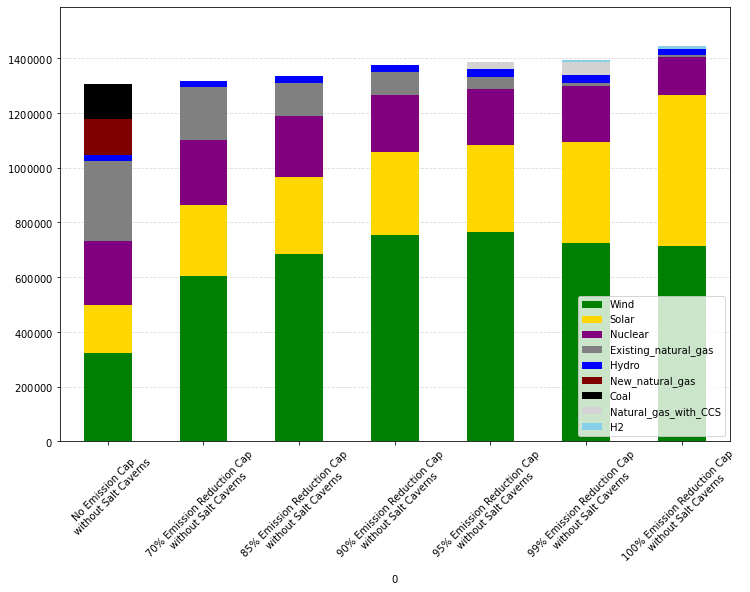

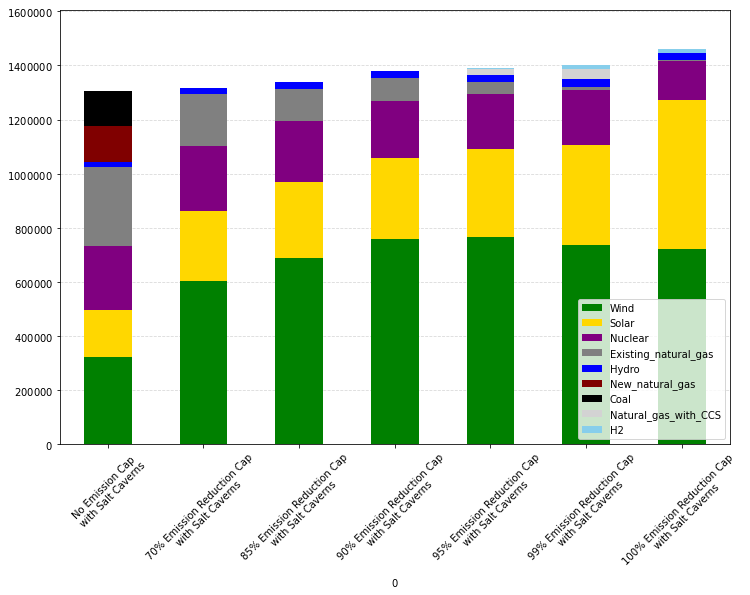

Scenarios present in 1 but missing in 2: Index([], dtype='object', name=0)
Scenarios present in 2 but missing in 1: Index([], dtype='object', name=0)


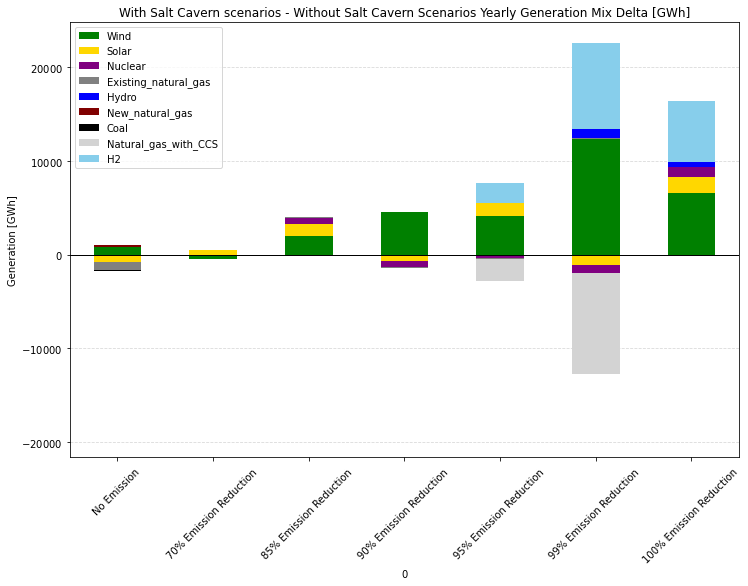

In [13]:
title = "With Salt Cavern scenarios - Without Salt Cavern Scenarios Yearly Generation Mix Delta [GWh]"
y_label = "Generation [GWh]"

df_diff = compare_scenarios(scenarios_no_caverns, scenarios_with_caverns, generation_power_barchart, title=title, y_label=y_label)

## Installed Capacity Comparison [GW]

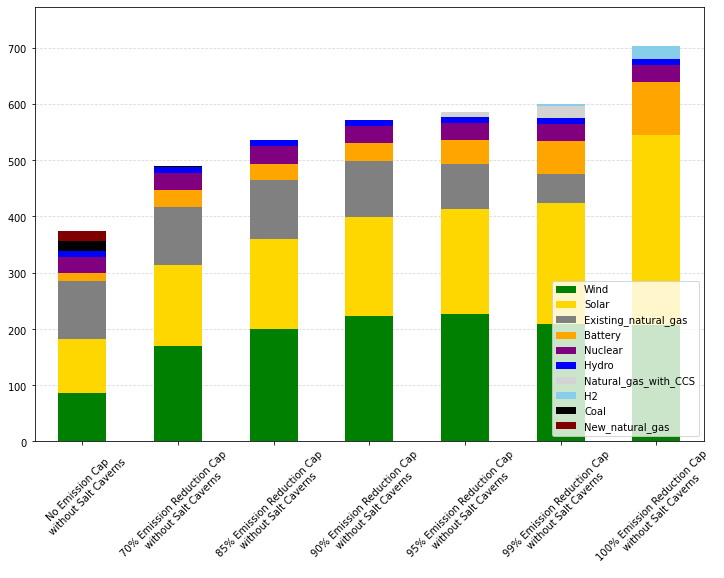

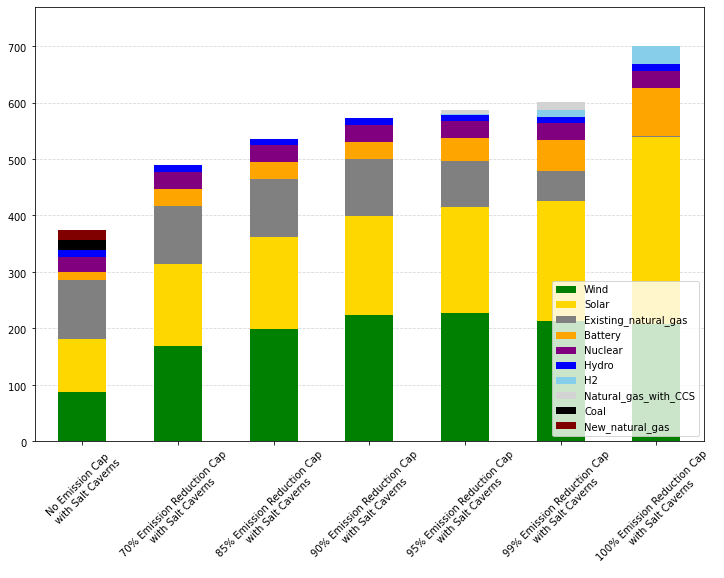

Scenarios present in 1 but missing in 2: Index([], dtype='object')
Scenarios present in 2 but missing in 1: Index([], dtype='object')


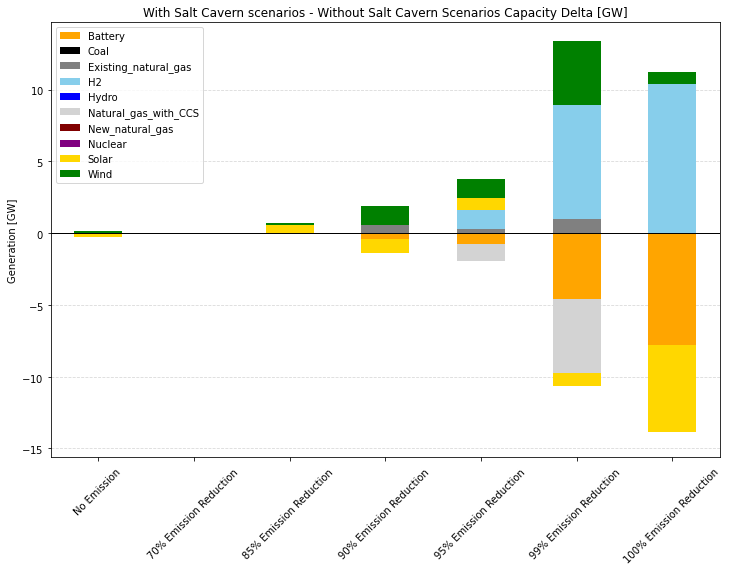

In [14]:
title = "With Salt Cavern scenarios - Without Salt Cavern Scenarios Capacity Delta [GW]"
y_label = "Generation [GW]"

df_diff = compare_scenarios(scenarios_no_caverns, scenarios_with_caverns, generation_capacity_barchart, title=title, y_label=y_label)

## H2 Generation Capacity [Metric Tons]

Tech_Type                       ATR_wCCS_94pct  Electrolyzer   Large_SMR  \
PJM_with_MI_no_caverns_0_red          0.014998      0.013540  224.316768   
PJM_with_MI_no_caverns_70_red         0.015666      0.113356  224.211590   
PJM_with_MI_no_caverns_85_red         0.081860     50.241075    5.233724   
PJM_with_MI_no_caverns_90_red         0.088355    191.244758    0.060501   
PJM_with_MI_no_caverns_95_red         0.230755    210.322410    0.098471   
PJM_with_MI_no_caverns_99_red         0.049762    228.729090    0.015583   
PJM_with_MI_no_caverns_100_red        0.000000    566.106022    0.000000   

Tech_Type                       Large_SMR_wCCS_96pct  
PJM_with_MI_no_caverns_0_red                0.032913  
PJM_with_MI_no_caverns_70_red               0.029964  
PJM_with_MI_no_caverns_85_red             205.635025  
PJM_with_MI_no_caverns_90_red             149.524254  
PJM_with_MI_no_caverns_95_red             123.026418  
PJM_with_MI_no_caverns_99_red             133.663603  
PJM_wi

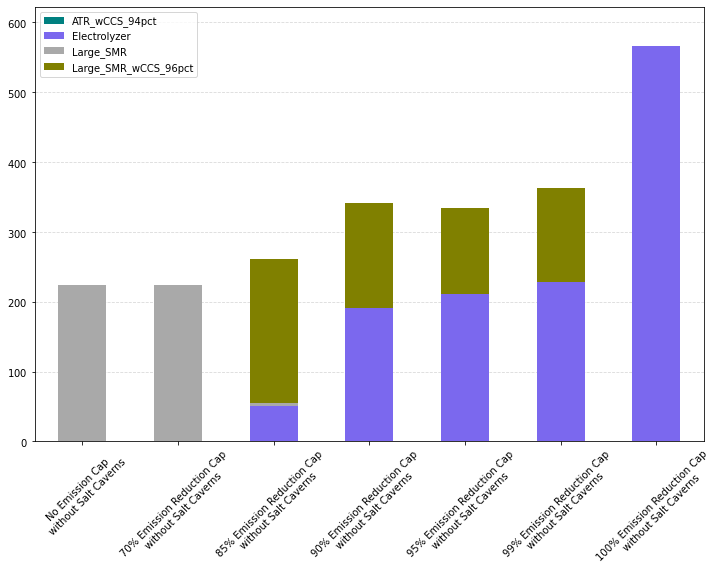

Tech_Type                         ATR_wCCS_94pct  Electrolyzer   Large_SMR  \
PJM_with_MI_with_caverns_0_red          0.001652      0.001333  224.313464   
PJM_with_MI_with_caverns_70_red         0.022267      0.154074  224.183241   
PJM_with_MI_with_caverns_85_red         0.029304     68.610149    2.931895   
PJM_with_MI_with_caverns_90_red         0.009940    204.884175    0.007209   
PJM_with_MI_with_caverns_95_red         0.148551    223.310148    0.033482   
PJM_with_MI_with_caverns_99_red         0.027340    259.439344    0.006543   
PJM_with_MI_with_caverns_100_red        0.000000    819.956130    0.000000   

Tech_Type                         Large_SMR_wCCS_96pct  
PJM_with_MI_with_caverns_0_red                0.004011  
PJM_with_MI_with_caverns_70_red               0.044469  
PJM_with_MI_with_caverns_85_red             199.351040  
PJM_with_MI_with_caverns_90_red             143.513529  
PJM_with_MI_with_caverns_95_red             124.430939  
PJM_with_MI_with_caverns_99_red  

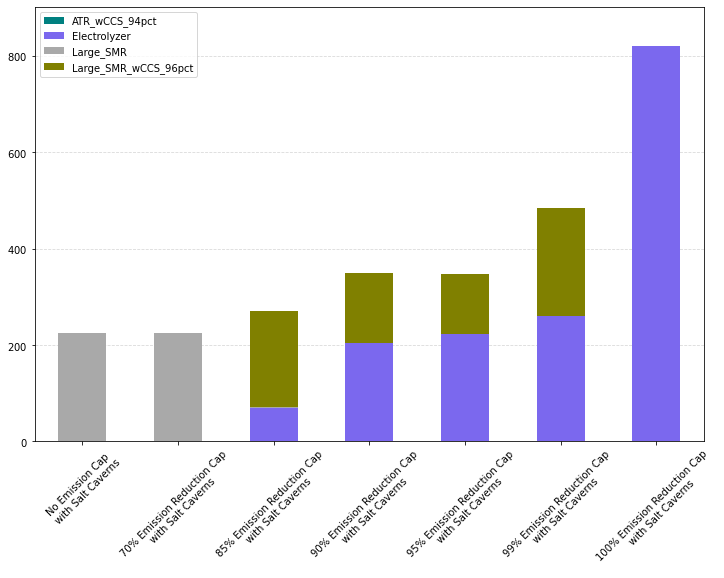

Scenarios present in 1 but missing in 2: Index([], dtype='object')
Scenarios present in 2 but missing in 1: Index([], dtype='object')


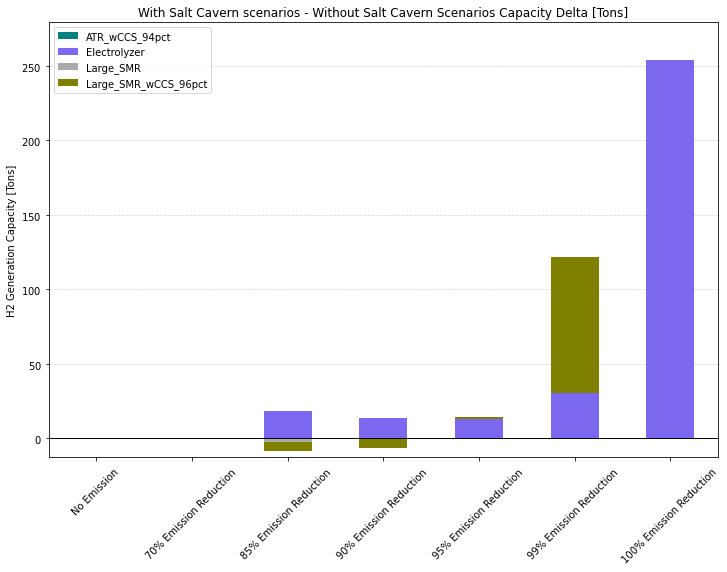

In [15]:
title = "With Salt Cavern scenarios - Without Salt Cavern Scenarios Capacity Delta [Tons]"
y_label = "H2 Generation Capacity [Tons]"

df_diff = compare_scenarios(scenarios_no_caverns, scenarios_with_caverns, h2_capacity_generation, units=2, title=title, y_label=y_label)

## Curtailment Analysis

In [16]:
def curtailment_analysis(scenario, generation_resource_categories=generation_resource_categories):
    df = open_results_file('curtail.csv', scenario)
    df = df.T
    df = df.reset_index()
    df.columns = df.iloc[0]
    df = df[1:]
    df = identify_tech_type(df, generation_resource_categories, aggregate=False)
    df.set_index('Resource', inplace=True)
    df = df[(df['Tech_Type'] == 'Solar') | (df['Tech_Type'] == 'Wind')]

    
    return(df)

def curtailment_barchart(scenarios, title=title, y_label=y_label, units=1):
    df_main = pd.DataFrame()

    for scenario in scenarios:
        df = curtailment_analysis(scenario)
        
        df_tech = df.groupby(['Tech_Type']).sum()
        df_tech = df_tech.rename(columns={'AnnualSum': scenario})
       
        df_tech = df_tech[scenario]
        
        
        df_main = df_main.append(df_tech, ignore_index=False)

    print(df_main)
    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)

                                       Solar          Wind
PJM_with_MI_no_caverns_0_red    1.050497e+06  1.167263e+06
PJM_with_MI_no_caverns_70_red   1.098171e+07  1.915410e+07
PJM_with_MI_no_caverns_85_red   1.724816e+07  4.524487e+07
PJM_with_MI_no_caverns_90_red   2.292988e+07  5.951713e+07
PJM_with_MI_no_caverns_95_red   2.499067e+07  5.942057e+07
PJM_with_MI_no_caverns_99_red   2.872059e+07  3.520018e+07
PJM_with_MI_no_caverns_100_red  6.538802e+07  3.878714e+07


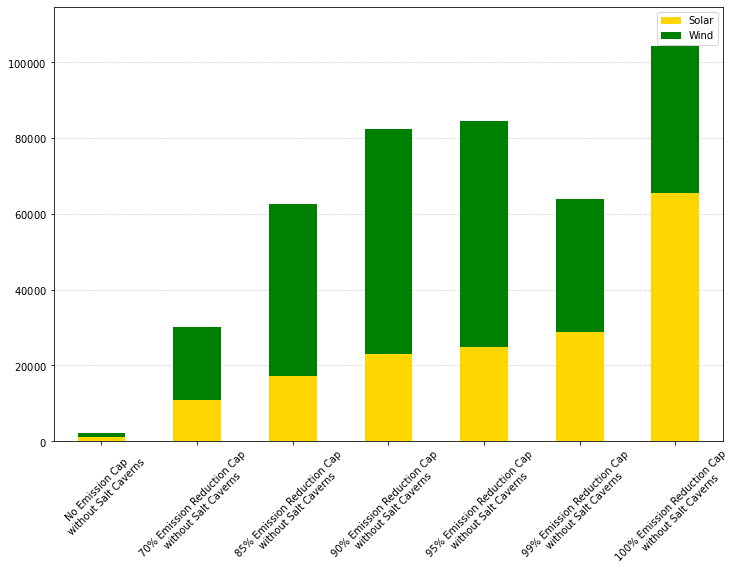

                                         Solar          Wind
PJM_with_MI_with_caverns_0_red    1.082585e+06  1.110496e+06
PJM_with_MI_with_caverns_70_red   1.053170e+07  1.961338e+07
PJM_with_MI_with_caverns_85_red   1.711758e+07  4.428525e+07
PJM_with_MI_with_caverns_90_red   2.195487e+07  6.042066e+07
PJM_with_MI_with_caverns_95_red   2.492360e+07  6.029767e+07
PJM_with_MI_with_caverns_99_red   2.754243e+07  3.870165e+07
PJM_with_MI_with_caverns_100_red  5.326650e+07  3.551578e+07


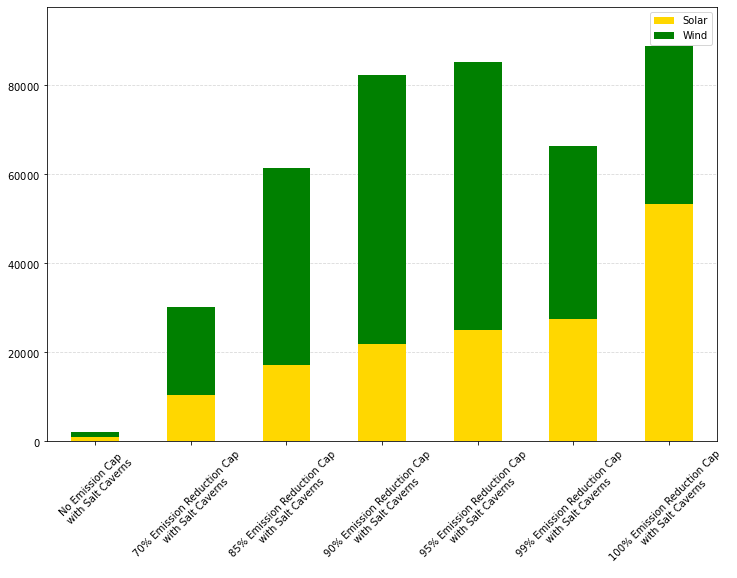

Scenarios present in 1 but missing in 2: Index([], dtype='object')
Scenarios present in 2 but missing in 1: Index([], dtype='object')


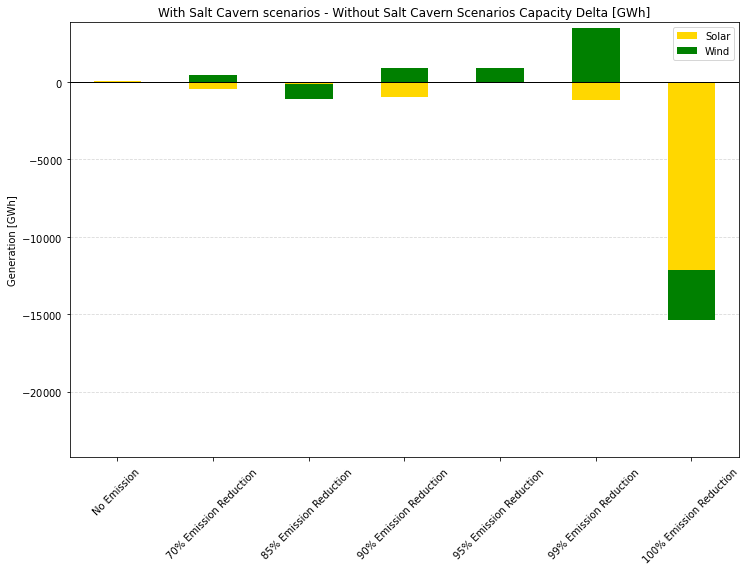

In [17]:
title = "With Salt Cavern scenarios - Without Salt Cavern Scenarios Capacity Delta [GWh]"
y_label = "Generation [GWh]"

df_diff = compare_scenarios(scenarios_no_caverns, scenarios_with_caverns, curtailment_barchart, units=1, title=title, y_label=y_label)

# Cost Analysis

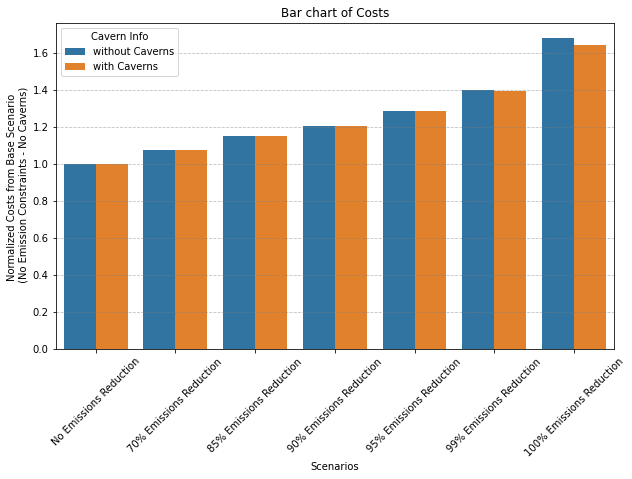

In [18]:
def extract_emission_scenario(s):
    if '_0_red' in s:
        return 'No Emissions Reduction'
    else:
        reduction = s.split('_')[-2]
        return f'{reduction}% Emissions Reduction'

    
scenarios_without_caverns = scenarios_no_caverns
scenarios_with_caverns

df_main = pd.DataFrame()
cavern_info = {} # Here's where we'll store the metadata

base_scenario = [s for s in scenarios_without_caverns if '_0_red' in s and 'no_cavern' in s][0]
df_base_scenario = open_results_file('costs_system.csv', base_scenario)
df_base_scenario.set_index('Costs', inplace=True)
df_base_scenario = df_base_scenario.loc[['cTotal'], ['Total']]
df_base_scenario = df_base_scenario.rename(columns={'Total': base_scenario})
base_scenario_cost = df_base_scenario.iloc[0][0]

for scenario in scenarios_without_caverns + scenarios_with_caverns:

    df = open_results_file('costs_system.csv', scenario)
    df.set_index('Costs', inplace=True)
    df = df.loc[['cTotal'], ['Total']]
    df = df.rename(columns={'Total': scenario})

    cavern_info[scenario] = 'with Caverns' if scenario in scenarios_with_caverns else 'without Caverns' # Update the metadata

    if df_main.empty:
        df_main = df
    else:
        df_main = df_main.join(df, how='outer')

df_main = df_main.T
df_main = df_main.astype(float) / base_scenario_cost
df_main.sort_values('cTotal')


df_plot = df_main.copy()#.sort_values('cTotal')
df_plot['Cavern Info'] = df_plot.index.map(cavern_info) # Add the metadata back    

    
# Reset the index so we can use the 'Scenario' as a column
df_plot.reset_index(inplace=True)
df_plot.rename(columns={'index':'Scenario'}, inplace=True)

# Create the new column 'Emission Scenario' using the function defined above
df_plot['Emission Scenario'] = df_plot['Scenario'].apply(extract_emission_scenario)



plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x='Emission Scenario', y='cTotal', hue='Cavern Info')
plt.title('Total Costs for Different Emission Scenarios')
plt.ylabel('Total Costs')
plt.xlabel('Emission Scenarios')
plt.grid(True,linestyle='--', which='major', color='gray', alpha=.5, axis='y') 
plt.xlabel('Scenarios')  
plt.ylabel('Normalized Costs from Base Scenario \n (No Emission Constraints - No Caverns)')
plt.title('Bar chart of Costs')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Cavern Info')
plt.show()



                               Difference  Order
No Emission Cap\n               -0.000658      1
100% Emission Reduction Cap\n   -0.036170      7
90% Emission Reduction Cap\n    -0.001422      4
95% Emission Reduction Cap\n    -0.002424      5
70% Emission Reduction Cap\n     0.000004      2
99% Emission Reduction Cap\n    -0.005566      6
85% Emission Reduction Cap\n    -0.000219      3


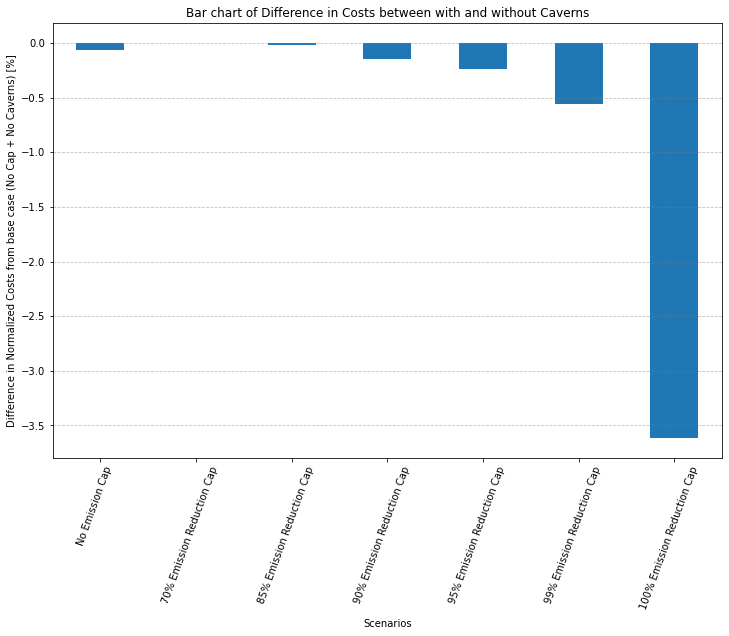

In [19]:
scenarios_without_caverns = scenarios_no_caverns

df_main = pd.DataFrame()
cavern_info = {} # Here's where we'll store the metadata

base_scenario = [s for s in scenarios_without_caverns if '_0_red' in s and 'no_cavern' in s][0]
df_base_scenario = open_results_file('costs_system.csv', base_scenario)
df_base_scenario.set_index('Costs', inplace=True)
df_base_scenario = df_base_scenario.loc[['cTotal'], ['Total']]
df_base_scenario = df_base_scenario.rename(columns={'Total': base_scenario})
base_scenario_cost = df_base_scenario.iloc[0][0]

for scenario in scenarios_without_caverns + scenarios_with_caverns:

    df = open_results_file('costs_system.csv', scenario)
    df.set_index('Costs', inplace=True)
    df = df.loc[['cTotal'], ['Total']]
    df = df.rename(columns={'Total': scenario})

    cavern_info[scenario] = 'with Caverns' if scenario in scenarios_with_caverns else 'without Caverns' # Update the metadata

    if df_main.empty:
        df_main = df
    else:
        df_main = df_main.join(df, how='outer')

df_main = df_main.T
df_main = (df_main.astype(float) - base_scenario_cost) / base_scenario_cost
df_main.sort_values('cTotal')

df_plot = df_main.copy()
df_plot['Cavern Info'] = df_plot.index.map(cavern_info) # Add the metadata back
df_plot.rename(index=rename_dict, inplace=True)

# List to hold the differences
differences = []

# Loop over unique scenario names
for scenario in set(df_plot.index.str.replace(" with Salt Caverns", "").str.replace(" without Salt Caverns", "")):
    # Get the values for the scenario with and without caverns
    with_caverns = df_plot.loc[scenario + " with Salt Caverns", "cTotal"]
    without_caverns = df_plot.loc[scenario + " without Salt Caverns", "cTotal"]
    
    # Calculate the difference and append to the list
    differences.append(with_caverns - without_caverns)

# Create a new DataFrame with the differences
df_differences = pd.DataFrame(differences, index=set(df_plot.index.str.replace(" with Salt Caverns", "").str.replace(" without Salt Caverns", "")), columns=["Difference"])



# Define the order
order_dict = {"No Emission Cap\n": 1,
              "70% Emission Reduction Cap\n": 2,
              "85% Emission Reduction Cap\n": 3,
              "90% Emission Reduction Cap\n": 4,
              "95% Emission Reduction Cap\n": 5,
              "99% Emission Reduction Cap\n": 6,
              "100% Emission Reduction Cap\n": 7}

# Add a new column to the DataFrame with the order
df_differences["Order"] = df_differences.index.map(order_dict)
print(df_differences)
# Sort by the new column
df_differences.sort_values("Order", inplace=True)

# Drop the order column
df_differences.drop("Order", axis=1, inplace=True)

# Plot the differences
# Convert 'Difference' to percentage
df_differences['Difference'] = df_differences['Difference'] * 100


# Create a figure with specified size (width, height)
fig, ax = plt.subplots(figsize=(12, 8))

# Plot
df_differences.plot(kind='bar', legend=False, ax=ax)
plt.grid(True, linestyle='--', which='major', color='gray', alpha=.5, axis='y')
plt.xlabel('Scenarios')  
plt.ylabel('Difference in Normalized Costs from base case (No Cap + No Caverns) [%]')  # indicate percentages in y-label
plt.title('Bar chart of Difference in Costs between with and without Caverns')
plt.xticks(rotation=70)  # Rotate x-axis labels for better visibility
plt.show()

#save_and_show_plot(fig, 'your_image_name')




# Emissions Analysis

In [20]:
def emissions_analysis(scenario, generation_resource_categories=generation_resource_categories):
    df_gen = open_results_file('emissions.csv', scenario)
    df_gen = df_gen.T
    df_gen.columns = df_gen.iloc[0]
    df_gen = df_gen.drop(df_gen.index[0])

    df_HSC = open_results_file('Results_HSC/HSC_emissions.csv', scenario)
    df_HSC = df_HSC.T
    df_HSC.columns = df_HSC.iloc[0]
    df_HSC = df_HSC.drop(df_HSC.index[0])

    # Get 'AnnualSum' column from each DataFrame and rename to match system
    power_system = df_gen['AnnualSum'].rename('Power System')
    h2_system = df_HSC['AnnualSum'].rename('H2 System')

    # Concatenate along axis=1 to create new DataFrame
    df = pd.concat([power_system, h2_system], axis=1)

    return(df)

In [21]:
def emissions_barchart(scenarios, title=title, y_label=y_label, units=4):
    df_main = pd.DataFrame()

    for scenario in scenarios:
        df = emissions_analysis(scenario)
        df = df.T
        df = df['Total']
        df_main = df_main.append(df, ignore_index=False)
        df_main = df_main.rename(index={'Total': scenario})
        #print(df_main)
    plot_stacked_barchart(df_main, title=title, y_label=y_label, units=units)
    return(df_main)

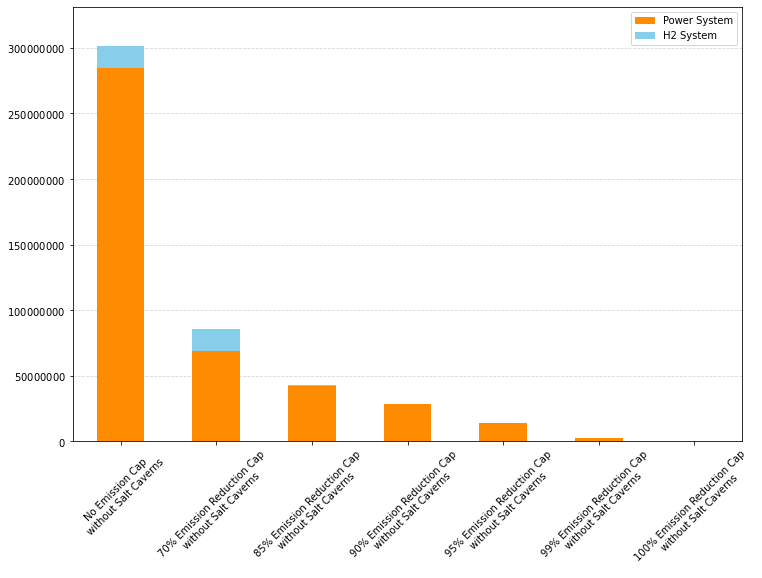

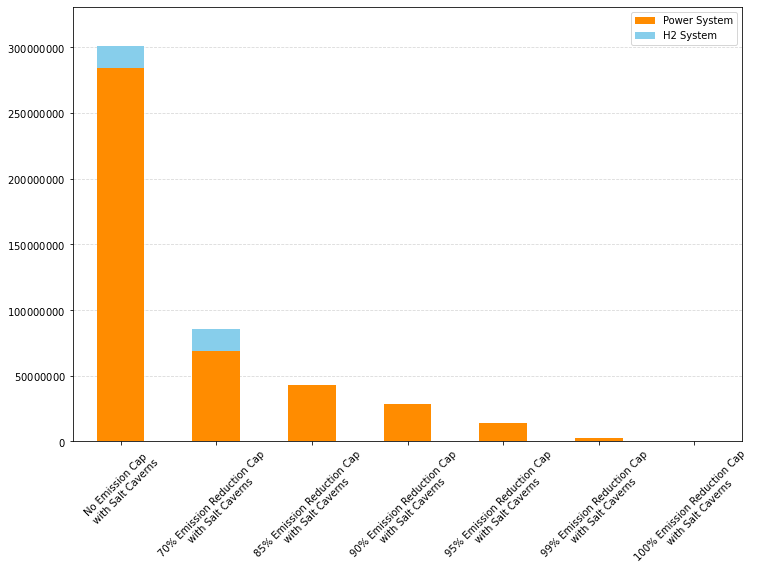

Scenarios present in 1 but missing in 2: Index([], dtype='object')
Scenarios present in 2 but missing in 1: Index([], dtype='object')


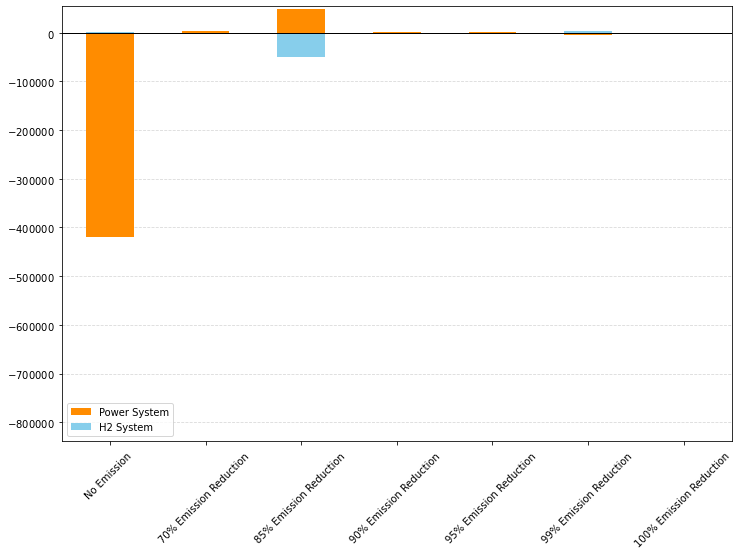

In [22]:
title = ''
y_label = ''

df_diff = compare_scenarios(scenarios_no_caverns, scenarios_with_caverns, emissions_barchart, units=4, title=title, y_label=y_label)

# Broad Scenarios Barcharts

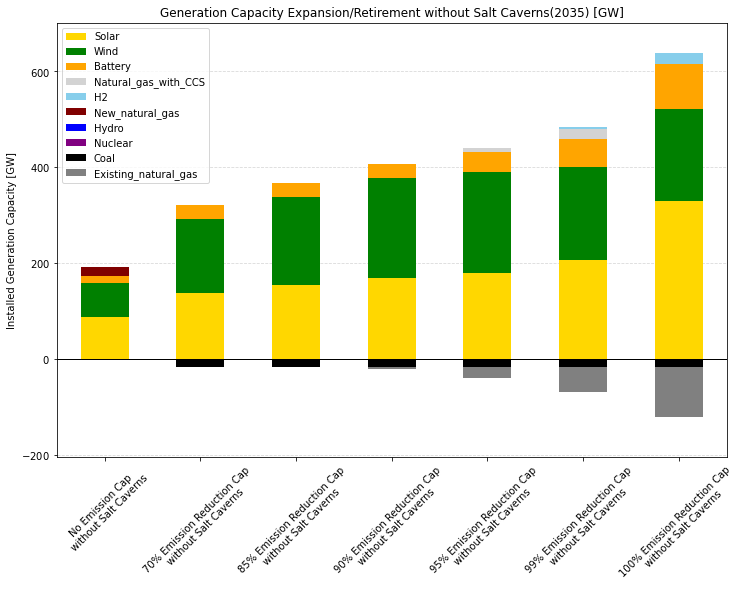

Tech_Type,Solar,Wind,Battery,Natural_gas_with_CCS,H2,New_natural_gas,Hydro,Nuclear,Coal,Existing_natural_gas
PJM_with_MI_no_caverns_0_red,86361.846299,72055.928257,14706.823588,0.481686,10.009012,18007.952675,0.0,-3332.965083,-0.095261,-0.315582
PJM_with_MI_no_caverns_70_red,136076.290398,154296.934560,29703.493825,0.237258,0.569024,2.801004,0.0,0.085555,-16950.882611,-0.010867
PJM_with_MI_no_caverns_85_red,153054.848363,184363.890770,29522.204451,0.481546,0.572194,0.706349,0.0,0.087236,-18294.487622,-0.052139
PJM_with_MI_no_caverns_90_red,168292.389472,207639.364165,30422.304576,1.309567,1.102483,0.588292,0.0,0.106702,-18294.645635,-3548.436794
PJM_with_MI_no_caverns_95_red,178566.359324,210856.800292,42151.597511,8057.630893,39.266734,2.087079,0.0,0.457350,-18293.113092,-22961.573006
PJM_with_MI_no_caverns_99_red,206640.468414,193329.317802,58820.192150,20186.024879,3499.402755,0.447239,0.0,0.129698,-18294.519221,-52105.365695
PJM_with_MI_no_caverns_100_red,329044.331703,192197.458351,93646.185536,0.000000,22234.588943,0.000000,0.0,5.576666,-18295.105000,-102975.488041


In [23]:
# No caverns generation retirement
title = 'Generation Capacity Expansion/Retirement without Salt Caverns(2035) [GW]'
y_label = 'Installed Generation Capacity [GW]'

generation_capacity_retirement_barchart(scenarios=scenarios_no_caverns, title=title, y_label=y_label)

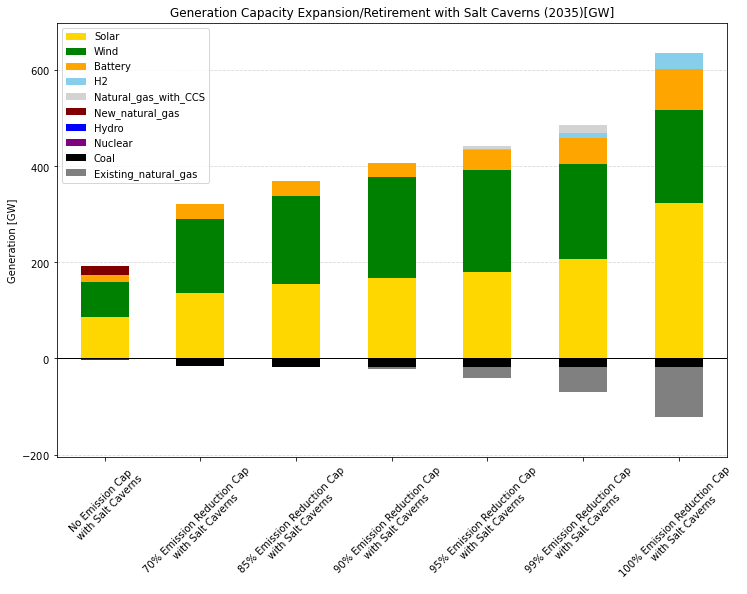

Tech_Type,Solar,Wind,Battery,H2,Natural_gas_with_CCS,New_natural_gas,Hydro,Nuclear,Coal,Existing_natural_gas
PJM_with_MI_with_caverns_0_red,86131.299731,72191.577572,14718.379694,6.049930,0.053116,18038.092272,0.0,-3337.507903,-0.015067,-0.044718
PJM_with_MI_with_caverns_70_red,136073.936877,154296.626663,29701.358249,0.859965,0.340559,3.028990,0.0,0.110905,-16949.909397,-0.013543
PJM_with_MI_with_caverns_85_red,153602.517540,184541.001141,29520.160475,0.213538,0.146189,0.256140,0.0,0.031246,-18294.862719,-0.017395
PJM_with_MI_with_caverns_90_red,167321.616414,208974.705612,30041.670147,0.185363,0.154310,0.089051,0.0,0.016851,-18295.025915,-2973.926021
PJM_with_MI_with_caverns_95_red,179374.360753,212204.298911,41372.806853,1340.405707,6908.934844,1.160133,0.0,0.335480,-18293.989022,-22652.500299
PJM_with_MI_with_caverns_99_red,205746.656595,197732.355381,54200.458070,11443.008068,15032.378787,0.200044,0.0,0.030272,-18294.798599,-51101.468307
PJM_with_MI_with_caverns_100_red,323014.933543,193084.168784,85840.090633,32591.171859,0.000000,0.000000,0.0,2.438944,-18295.105000,-102975.488258


In [24]:
# With caverns generation retirement
title = 'Generation Capacity Expansion/Retirement with Salt Caverns (2035)[GW]'
y_label = 'Generation [GW]'
generation_capacity_retirement_barchart(scenarios=scenarios_with_caverns, title=title, y_label=y_label)

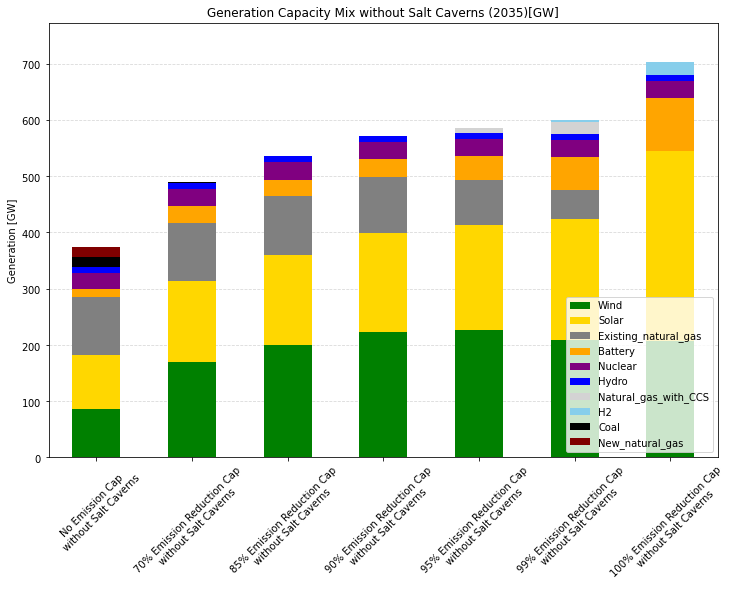

Tech_Type,Wind,Solar,Existing_natural_gas,Battery,Nuclear,Hydro,Natural_gas_with_CCS,H2,Coal,New_natural_gas
PJM_with_MI_no_caverns_0_red,86748.948257,94682.127299,103798.272418,14706.823588,27140.734917,11190.736,0.481686,10.009012,18295.009739,18007.952675
PJM_with_MI_no_caverns_70_red,168989.954560,144396.571398,103798.577133,29703.493825,30473.785555,11190.736,0.237258,0.569024,1344.222389,2.801004
PJM_with_MI_no_caverns_85_red,199056.910770,161375.129363,103798.535861,29522.204451,30473.787236,11190.736,0.481546,0.572194,0.617378,0.706349
PJM_with_MI_no_caverns_90_red,222332.384165,176612.670472,100250.151206,30422.304576,30473.806702,11190.736,1.309567,1.102483,0.459365,0.588292
PJM_with_MI_no_caverns_95_red,225549.820292,186886.640324,80837.014994,42151.597511,30474.157350,11190.736,8057.630893,39.266734,1.991908,2.087079
PJM_with_MI_no_caverns_99_red,208022.337802,214960.749414,51693.222305,58820.192150,30473.829698,11190.736,20186.024879,3499.402755,0.585779,0.447239
PJM_with_MI_no_caverns_100_red,206890.478351,337364.612703,823.099959,93646.185536,30479.276666,11190.736,0.000000,22234.588943,0.000000,0.000000


In [25]:
# With caverns generation retirement
title = 'Generation Capacity Mix without Salt Caverns (2035)[GW]'
y_label = 'Generation [GW]'
generation_capacity_barchart(scenarios=scenarios_no_caverns, title=title, y_label=y_label)

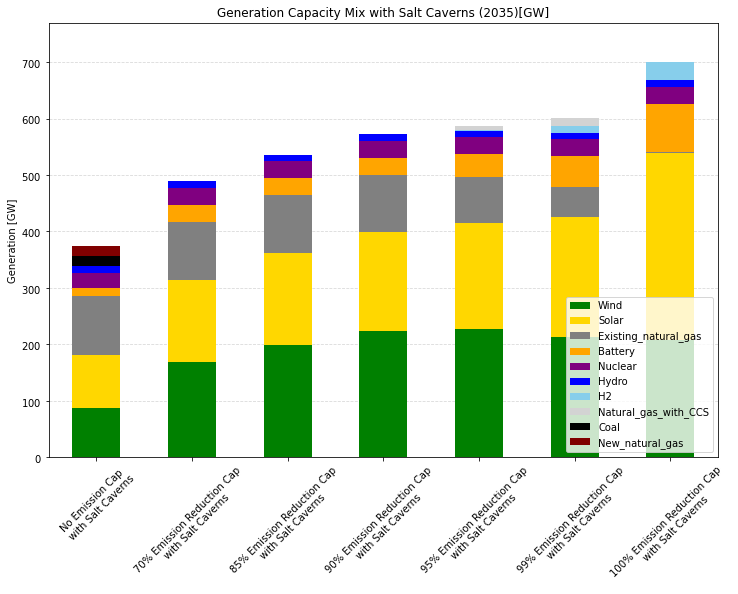

Tech_Type,Wind,Solar,Existing_natural_gas,Battery,Nuclear,Hydro,H2,Natural_gas_with_CCS,Coal,New_natural_gas
PJM_with_MI_with_caverns_0_red,86884.597572,94451.580731,103798.543282,14718.379694,27136.192097,11190.736,6.049930,0.053116,18295.089933,18038.092272
PJM_with_MI_with_caverns_70_red,168989.646663,144394.217877,103798.574457,29701.358249,30473.810905,11190.736,0.859965,0.340559,1345.195603,3.028990
PJM_with_MI_with_caverns_85_red,199234.021141,161922.798540,103798.570605,29520.160475,30473.731246,11190.736,0.213538,0.146189,0.242281,0.256140
PJM_with_MI_with_caverns_90_red,223667.725612,175641.897414,100824.661979,30041.670147,30473.716851,11190.736,0.185363,0.154310,0.079085,0.089051
PJM_with_MI_with_caverns_95_red,226897.318911,187694.641753,81146.087701,41372.806853,30474.035480,11190.736,1340.405707,6908.934844,1.115978,1.160133
PJM_with_MI_with_caverns_99_red,212425.375381,214066.937595,52697.119693,54200.458070,30473.730272,11190.736,11443.008068,15032.378787,0.306401,0.200044
PJM_with_MI_with_caverns_100_red,207777.188784,331335.214543,823.099742,85840.090633,30476.138944,11190.736,32591.171859,0.000000,0.000000,0.000000


In [26]:
# With caverns generation retirement
title = 'Generation Capacity Mix with Salt Caverns (2035)[GW]'
y_label = 'Generation [GW]'
generation_capacity_barchart(scenarios=scenarios_with_caverns, title=title, y_label=y_label)

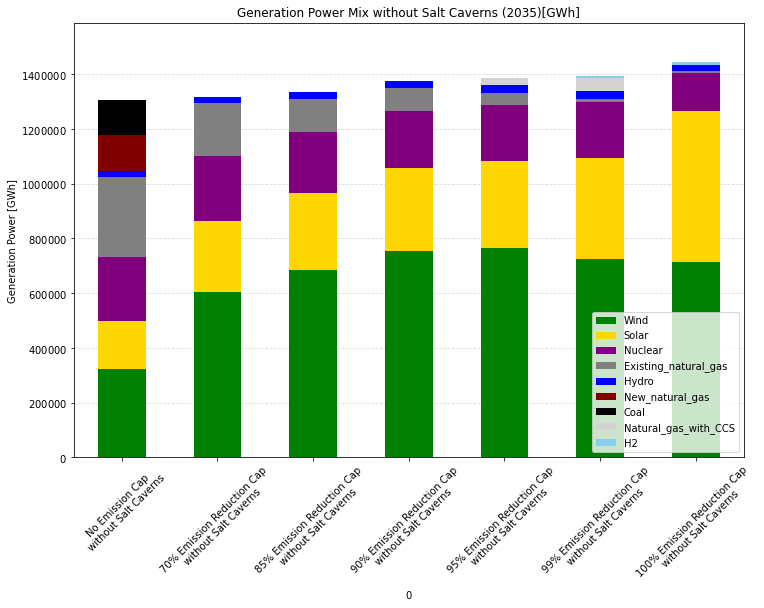

Tech_Type,Wind,Solar,Nuclear,Existing_natural_gas,Hydro,New_natural_gas,Coal,Natural_gas_with_CCS,H2
0,,,,,,,,,
PJM_with_MI_no_caverns_0_red,3.211175e+08,1.765005e+08,2.351276e+08,2.931513e+08,1.916565e+07,1.334250e+08,1.261715e+08,2.273920e+03,4.231222e+03
PJM_with_MI_no_caverns_70_red,6.040753e+08,2.589149e+08,2.388385e+08,1.912079e+08,2.323594e+07,1.285716e+04,5.115907e+03,1.376793e+03,2.783117e+02
PJM_with_MI_no_caverns_85_red,6.858143e+08,2.815163e+08,2.221480e+08,1.198791e+08,2.643903e+07,1.967360e+03,2.150355e+02,2.601279e+03,6.704703e+02
PJM_with_MI_no_caverns_90_red,7.528899e+08,3.026658e+08,2.110736e+08,8.231830e+07,2.711987e+07,1.476650e+03,1.685262e+02,5.525001e+03,1.594314e+03
PJM_with_MI_no_caverns_95_red,7.638304e+08,3.200890e+08,2.042352e+08,4.449576e+07,2.692493e+07,4.269931e+03,5.390591e+02,2.567673e+07,4.659498e+04
PJM_with_MI_no_caverns_99_red,7.247256e+08,3.683296e+08,2.044092e+08,1.343818e+07,2.582833e+07,3.150088e+02,5.069138e+01,5.088279e+07,3.747708e+06
PJM_with_MI_no_caverns_100_red,7.135534e+08,5.511628e+08,1.407829e+08,5.393304e+06,2.334721e+07,0.000000e+00,0.000000e+00,0.000000e+00,9.842420e+06


In [27]:
# With caverns generation retirement
title = 'Generation Power Mix without Salt Caverns (2035)[GWh]'
y_label = 'Generation Power [GWh]'
generation_power_barchart(scenarios=scenarios_no_caverns, title=title, y_label=y_label)


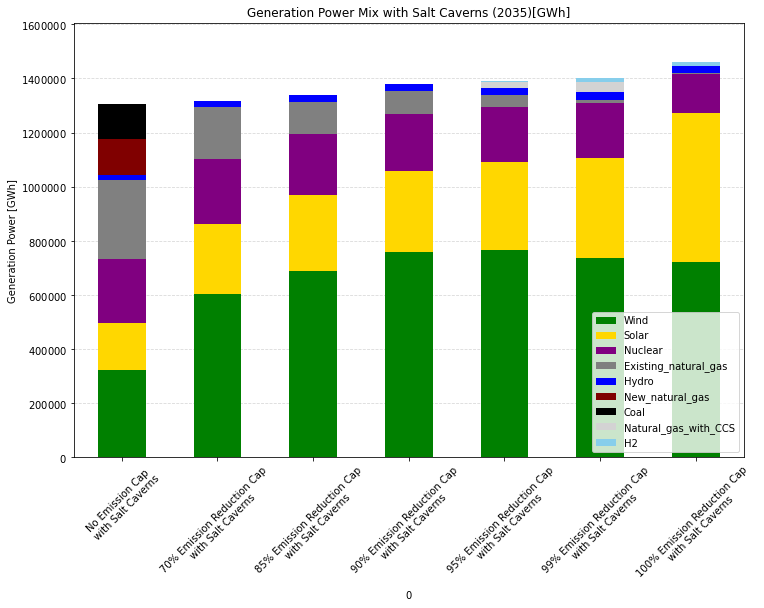

Tech_Type,Wind,Solar,Nuclear,Existing_natural_gas,Hydro,New_natural_gas,Coal,Natural_gas_with_CCS,H2
0,,,,,,,,,
PJM_with_MI_with_caverns_0_red,3.219587e+08,1.757487e+08,2.350733e+08,2.922919e+08,1.918408e+07,1.335591e+08,1.260708e+08,2.616634e+02,2.009912e+03
PJM_with_MI_with_caverns_70_red,6.036145e+08,2.593612e+08,2.388422e+08,1.912142e+08,2.323781e+07,1.348833e+04,5.167800e+03,1.973475e+03,4.485438e+02
PJM_with_MI_with_caverns_85_red,6.877530e+08,2.828722e+08,2.227806e+08,1.200139e+08,2.641902e+07,7.697683e+02,9.054312e+01,7.828040e+02,2.247702e+02
PJM_with_MI_with_caverns_90_red,7.574744e+08,3.019845e+08,2.104600e+08,8.222187e+07,2.703531e+07,2.235351e+02,2.871142e+01,6.802289e+02,2.783031e+02
PJM_with_MI_with_caverns_95_red,7.679541e+08,3.215051e+08,2.038503e+08,4.437704e+07,2.692475e+07,2.239684e+03,2.647943e+02,2.335254e+07,2.151232e+06
PJM_with_MI_with_caverns_99_red,7.370821e+08,3.672615e+08,2.035471e+08,1.351416e+07,2.685081e+07,1.583285e+02,2.528531e+01,4.005402e+07,1.286144e+07
PJM_with_MI_with_caverns_100_red,7.200998e+08,5.528791e+08,1.418548e+08,5.441427e+06,2.382580e+07,0.000000e+00,0.000000e+00,0.000000e+00,1.637667e+07


In [28]:
# With caverns generation retirement
title = 'Generation Power Mix with Salt Caverns (2035)[GWh]'
y_label = 'Generation Power [GWh]'
generation_power_barchart(scenarios=scenarios_with_caverns, title=title, y_label=y_label)


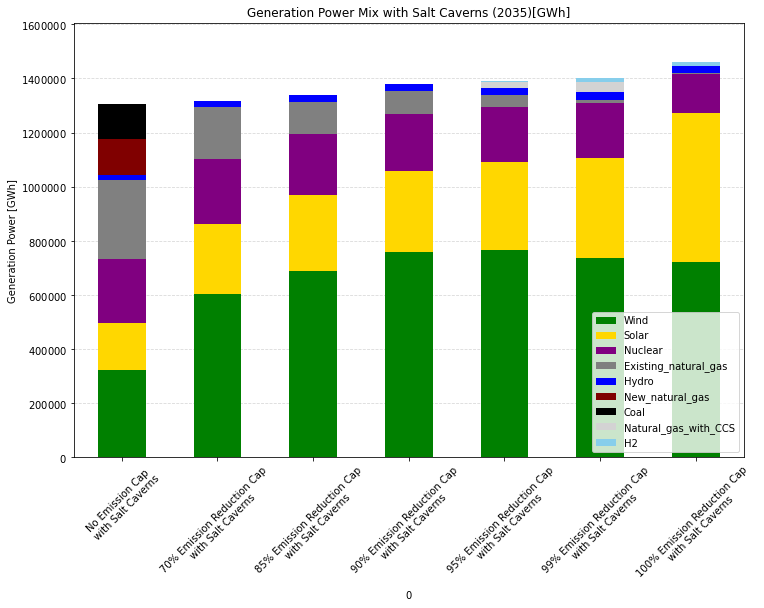

Tech_Type,Wind,Solar,Nuclear,Existing_natural_gas,Hydro,New_natural_gas,Coal,Natural_gas_with_CCS,H2
0,,,,,,,,,
PJM_with_MI_with_caverns_0_red,3.219587e+08,1.757487e+08,2.350733e+08,2.922919e+08,1.918408e+07,1.335591e+08,1.260708e+08,2.616634e+02,2.009912e+03
PJM_with_MI_with_caverns_70_red,6.036145e+08,2.593612e+08,2.388422e+08,1.912142e+08,2.323781e+07,1.348833e+04,5.167800e+03,1.973475e+03,4.485438e+02
PJM_with_MI_with_caverns_85_red,6.877530e+08,2.828722e+08,2.227806e+08,1.200139e+08,2.641902e+07,7.697683e+02,9.054312e+01,7.828040e+02,2.247702e+02
PJM_with_MI_with_caverns_90_red,7.574744e+08,3.019845e+08,2.104600e+08,8.222187e+07,2.703531e+07,2.235351e+02,2.871142e+01,6.802289e+02,2.783031e+02
PJM_with_MI_with_caverns_95_red,7.679541e+08,3.215051e+08,2.038503e+08,4.437704e+07,2.692475e+07,2.239684e+03,2.647943e+02,2.335254e+07,2.151232e+06
PJM_with_MI_with_caverns_99_red,7.370821e+08,3.672615e+08,2.035471e+08,1.351416e+07,2.685081e+07,1.583285e+02,2.528531e+01,4.005402e+07,1.286144e+07
PJM_with_MI_with_caverns_100_red,7.200998e+08,5.528791e+08,1.418548e+08,5.441427e+06,2.382580e+07,0.000000e+00,0.000000e+00,0.000000e+00,1.637667e+07


In [29]:
# With caverns generation retirement
title = 'Generation Power Mix with Salt Caverns (2035)[GWh]'
y_label = 'Generation Power [GWh]'
generation_power_barchart(scenarios=scenarios_with_caverns, title=title, y_label=y_label)


Tech_Type                         ATR_wCCS_94pct  Electrolyzer   Large_SMR  \
PJM_with_MI_with_caverns_0_red          0.001652      0.001333  224.313464   
PJM_with_MI_with_caverns_70_red         0.022267      0.154074  224.183241   
PJM_with_MI_with_caverns_85_red         0.029304     68.610149    2.931895   
PJM_with_MI_with_caverns_90_red         0.009940    204.884175    0.007209   
PJM_with_MI_with_caverns_95_red         0.148551    223.310148    0.033482   
PJM_with_MI_with_caverns_99_red         0.027340    259.439344    0.006543   
PJM_with_MI_with_caverns_100_red        0.000000    819.956130    0.000000   

Tech_Type                         Large_SMR_wCCS_96pct  
PJM_with_MI_with_caverns_0_red                0.004011  
PJM_with_MI_with_caverns_70_red               0.044469  
PJM_with_MI_with_caverns_85_red             199.351040  
PJM_with_MI_with_caverns_90_red             143.513529  
PJM_with_MI_with_caverns_95_red             124.430939  
PJM_with_MI_with_caverns_99_red  

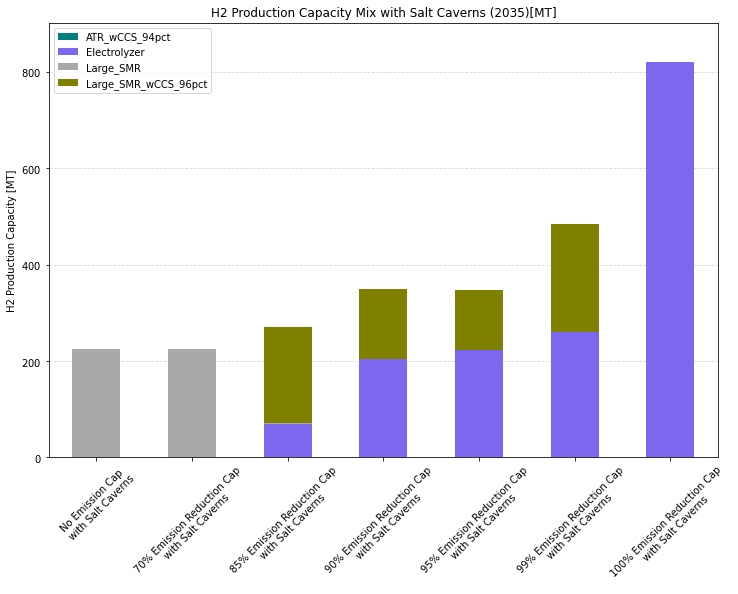

Tech_Type,ATR_wCCS_94pct,Electrolyzer,Large_SMR,Large_SMR_wCCS_96pct
No Emission Cap\n with Salt Caverns,0.001652,0.001333,224.313464,0.004011
70% Emission Reduction Cap\n with Salt Caverns,0.022267,0.154074,224.183241,0.044469
85% Emission Reduction Cap\n with Salt Caverns,0.029304,68.610149,2.931895,199.351040
90% Emission Reduction Cap\n with Salt Caverns,0.009940,204.884175,0.007209,143.513529
95% Emission Reduction Cap\n with Salt Caverns,0.148551,223.310148,0.033482,124.430939
99% Emission Reduction Cap\n with Salt Caverns,0.027340,259.439344,0.006543,224.667514
100% Emission Reduction Cap\n with Salt Caverns,0.000000,819.956130,0.000000,0.000000


In [30]:
# With caverns generation retirement
title = 'H2 Production Capacity Mix with Salt Caverns (2035)[MT]'
y_label = 'H2 Production Capacity [MT]'
h2_capacity_generation(scenarios=scenarios_with_caverns, title=title, y_label=y_label)


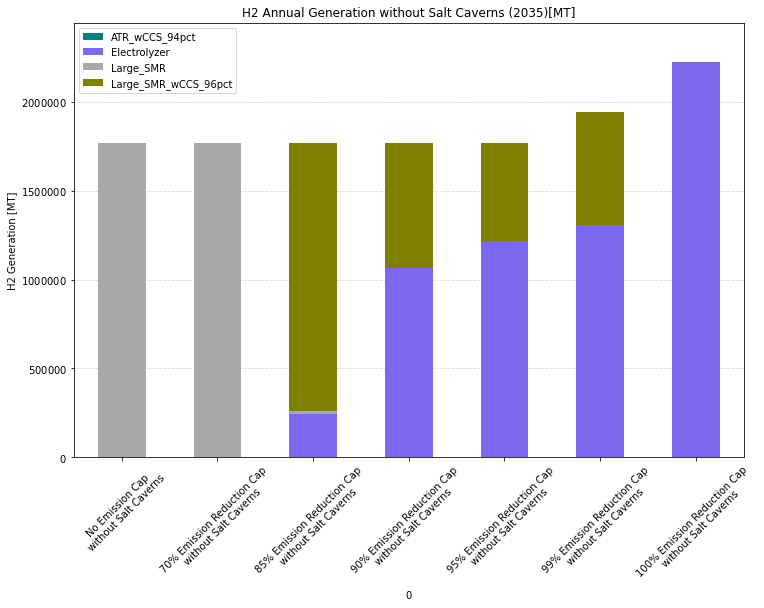

Tech_Type,ATR_wCCS_94pct,Electrolyzer,Large_SMR,Large_SMR_wCCS_96pct
0,,,,
No Emission Cap\n without Salt Caverns,114.943704,5.264580e+01,1.768098e+06,1.653120e+02
70% Emission Reduction Cap\n without Salt Caverns,120.727319,4.225574e+02,1.767464e+06,2.128923e+02
85% Emission Reduction Cap\n without Salt Caverns,632.282909,2.445495e+05,1.305595e+04,1.510002e+06
90% Emission Reduction Cap\n without Salt Caverns,680.117502,1.062909e+06,1.032626e+02,7.045943e+05
95% Emission Reduction Cap\n without Salt Caverns,1774.233290,1.212530e+06,1.270874e+02,5.560588e+05
99% Emission Reduction Cap\n without Salt Caverns,382.766608,1.306565e+06,3.974067e+00,6.344139e+05
100% Emission Reduction Cap\n without Salt Caverns,0.000000,2.223267e+06,0.000000e+00,0.000000e+00


In [31]:
# With caverns generation retirement
title = 'H2 Annual Generation without Salt Caverns (2035)[MT]'
y_label = 'H2 Generation [MT]'
h2_generation(scenarios=scenarios_no_caverns, title=title, y_label=y_label)

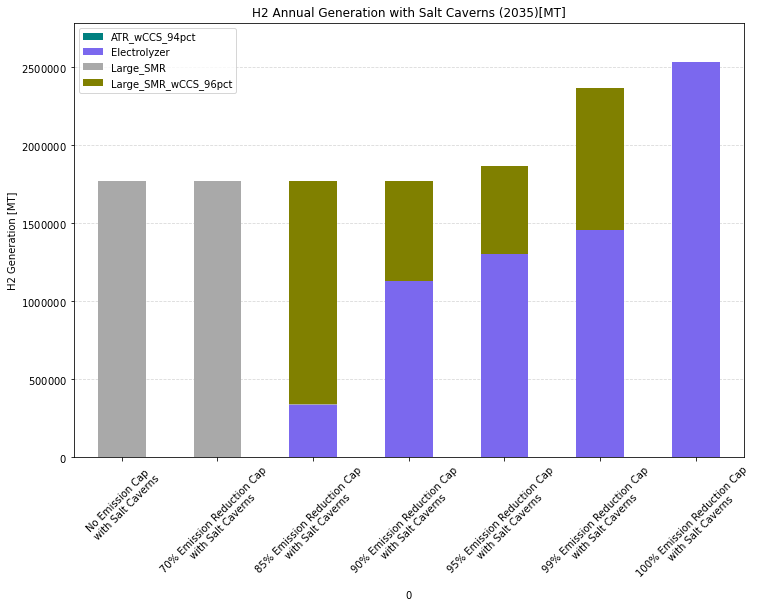

Tech_Type,ATR_wCCS_94pct,Electrolyzer,Large_SMR,Large_SMR_wCCS_96pct
0,,,,
No Emission Cap\n with Salt Caverns,12.656225,4.214965e+00,1.768280e+06,2.005282e+01
70% Emission Reduction Cap\n with Salt Caverns,171.519552,5.765924e+02,1.767165e+06,3.153221e+02
85% Emission Reduction Cap\n with Salt Caverns,226.464016,3.329736e+05,7.892359e+03,1.427125e+06
90% Emission Reduction Cap\n with Salt Caverns,76.517942,1.126400e+06,1.359543e+01,6.417298e+05
95% Emission Reduction Cap\n with Salt Caverns,1144.628636,1.302220e+06,4.890913e+01,5.642110e+05
99% Emission Reduction Cap\n with Salt Caverns,210.278440,1.456279e+06,1.824684e+00,9.077520e+05
100% Emission Reduction Cap\n with Salt Caverns,0.000000,2.531108e+06,0.000000e+00,0.000000e+00


In [32]:
# With caverns generation retirement
title = 'H2 Annual Generation with Salt Caverns (2035)[MT]'
y_label = 'H2 Generation [MT]'
h2_generation(scenarios=scenarios_with_caverns, title=title, y_label=y_label)

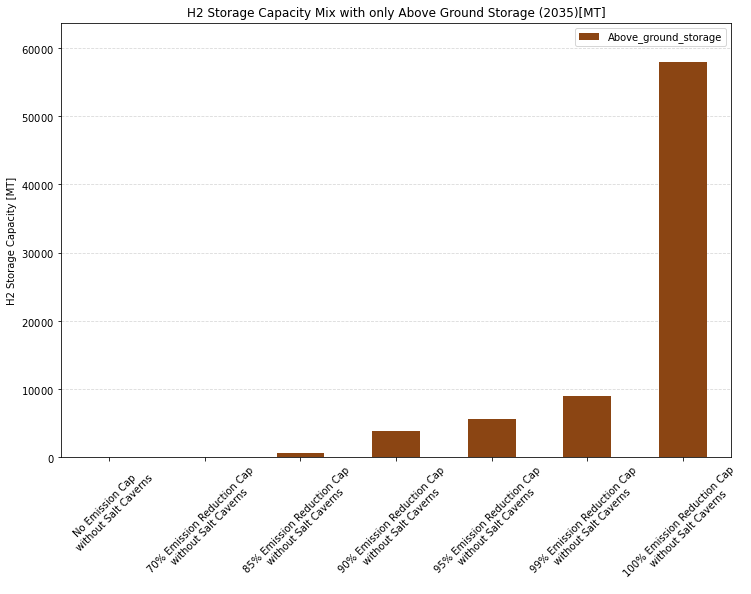

Tech_Type,Above_ground_storage
No Emission Cap\n without Salt Caverns,0.823747
70% Emission Reduction Cap\n without Salt Caverns,0.207288
85% Emission Reduction Cap\n without Salt Caverns,637.457901
90% Emission Reduction Cap\n without Salt Caverns,3851.640487
95% Emission Reduction Cap\n without Salt Caverns,5562.698506
99% Emission Reduction Cap\n without Salt Caverns,8923.435900
100% Emission Reduction Cap\n without Salt Caverns,57918.423721


In [33]:
# With caverns generation retirement
title = 'H2 Storage Capacity Mix with only Above Ground Storage (2035)[MT]'
y_label = 'H2 Storage Capacity [MT]'
h2_storage_capacity_barchart(scenarios=scenarios_no_caverns, title=title, y_label=y_label)


# Spatial Analysis

## Zonal Barcharts

In [34]:
def spatial_scenario_dict_creator(result_file, scenarios=scenarios):
    dataframes_dict = {}
    for scenario in scenarios:
        #print(scenario)

        df = open_results_file(result_file, scenario)
        df = df.T
        #identify_tech_type(df, resources, aggregate=False)
        df = df.reset_index()
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'Zone': 'Zone_N'})

        df = identify_tech_type(df, resources=H2_resource_categories, aggregate=False)
        df = df.iloc[:-1]
        df = df.reset_index()
        df['Zone'] = df['Resource'].apply(lambda resource: next((zone for zone in zones if zone in resource), None))

        # Group the dataframe by 'Zone_N'
        zoned = df.groupby('Zone')

        # Create a double key dictionary of dataframes. Keys are scenario and zone

        for zone, group in zoned:
            dataframes_dict[zone, scenario] = group
    return(dataframes_dict)

dataframes_dict = spatial_scenario_dict_creator(result_file='HSC_h2_generation_discharge.csv', scenarios=scenarios)
dataframes_dict[zones[0], scenarios[0]]

,index,Resource,Zone_N,AnnualSum,t1,t2,t3,t4,t5,t6,...,t1841,t1842,t1843,t1844,t1845,t1846,t1847,t1848,Tech_Type,Zone
0,1,MIS_INKY_Electrolyzer,1.0,4.263863,0.00066,0.001007,0.001008,0.001045,0.001046,0.001046,...,0.000512,0.000352,0.000335,0.00034,0.000354,0.000398,0.000394,0.000419,Electrolyzer,MIS_INKY
12,13,MIS_INKY_Large_SMR,1.0,507286.28,57.908016,57.908303,57.908386,57.908524,57.908566,57.908579,...,57.909431,57.90923,57.909139,57.909096,57.909109,57.909147,57.909163,57.909181,Large_SMR,MIS_INKY
24,25,MIS_INKY_Large_SMR_wCCS_96pct,1.0,13.981671,0.001698,0.001709,0.001717,0.001724,0.001727,0.001728,...,0.001441,0.001415,0.001402,0.001397,0.001399,0.001403,0.001406,0.001407,Large_SMR_wCCS_96pct,MIS_INKY
36,37,MIS_INKY_ATR_wCCS_94pct,1.0,9.716841,0.00111,0.00111,0.00111,0.00111,0.00111,0.00111,...,0.001109,0.001109,0.001109,0.001109,0.001109,0.001109,0.001109,0.001109,ATR_wCCS_94pct,MIS_INKY
48,49,MIS_INKY_Above_ground_storage,1.0,57.217785,0.00751,0.011036,0.009793,0.011283,0.010728,0.010469,...,0.004897,0.004705,0.004871,0.004966,0.005108,0.005438,0.005793,0.006004,Above_ground_storage,MIS_INKY


In [35]:
def spatial_scenario_dict_creator_v2(result_file, scenarios=scenarios):
    dataframes_dict = {}
    for scenario in scenarios:
        #print(scenario)
        df_HSC_h2_balance = HSC_h2_balance_dict()
        # Group the dataframe by 'Zone_N'

        # Create a double key dictionary of dataframes. Keys are scenario and zone

        for zone in zones:
            dataframes_dict[zone, scenario] = df_HSC_h2_balance.loc[zone]
    return(dataframes_dict)


spatial_scenario_dict_creator_v2(result_file='HSC_h2_generation_discharge.csv', scenarios=scenarios)
#dataframes_dict

{('MIS_INKY',
  'PJM_with_MI_no_caverns_0_red'): Demand                           -507204.0
 Generation                   593209.753235
 H2G2P                           -28.596049
 H2_Pipeline_Import/Export    -85977.157169
 Name: MIS_INKY, dtype: object,
 ('PJM_WMAC',
  'PJM_with_MI_no_caverns_0_red'): Demand                           -38368.8
 Generation                   38718.027141
 H2G2P                          -22.783012
 H2_Pipeline_Import/Export     -326.444113
 Name: PJM_WMAC, dtype: object,
 ('PJM_SMAC',
  'PJM_with_MI_no_caverns_0_red'): Demand                           -46778.4
 Generation                   48528.866391
 H2G2P                           -35.87995
 H2_Pipeline_Import/Export    -1714.586426
 Name: PJM_SMAC, dtype: object,
 ('PJM_West',
  'PJM_with_MI_no_caverns_0_red'): Demand                           -227322.0
 Generation                   225552.989226
 H2G2P                           -20.358739
 H2_Pipeline_Import/Export      1789.369529
 Name: PJM_West,

In [36]:
def multiple_zone_barchart_plot(dataframes_dict, scenarios=scenarios, zones=zones):

    # Finds max value which allows me to set scale for all the barplots relative to each other

    max_value = 0

    for keys, df in dataframes_dict.items():
        filtered_df = df[~df['Tech_Type'].str.contains('storage')]
        max_in_df = filtered_df['AnnualSum'].max()

        if max_in_df > max_value:
            max_value = max_in_df
    
    # Find load data for each zone
    h2_load_zoned = zone_h2_load_data()
    
    for zone in zones:

        df_main = pd.DataFrame()

        for scenario in scenarios:
            dff = dataframes_dict[(zone,scenario)]

            dff = dff[['Tech_Type', 'AnnualSum']]
            #dff = dff.set_index('Tech_Type')


            dff = dff.rename(columns={'AnnualSum': scenario})#

            dff = dff[dff['Tech_Type'] != 'Above_ground_storage']
            dff = dff[dff['Tech_Type'] != 'Salt_cavern_storage']

            # Transpose the dataframe    
            dff = dff.set_index('Tech_Type').T
            #dff = dff.columns = dff.columns.droplevel(0)
            #dff = dff.set_index('Tech_Type', inplace=True)
            #

            #dff.reset_index()
            df_main = df_main.append(dff, ignore_index=False)

        plot_stacked_barchart(df_main=df_main, title=zone, legend_title="H2 Generator", y_label="", units=2,
                              retirement=False, sort_values=False, legend_custom=False, comparing=False,
                               spatial_shared_y_limit=max_value, load_data=h2_load_zoned[zone])


    #df_main


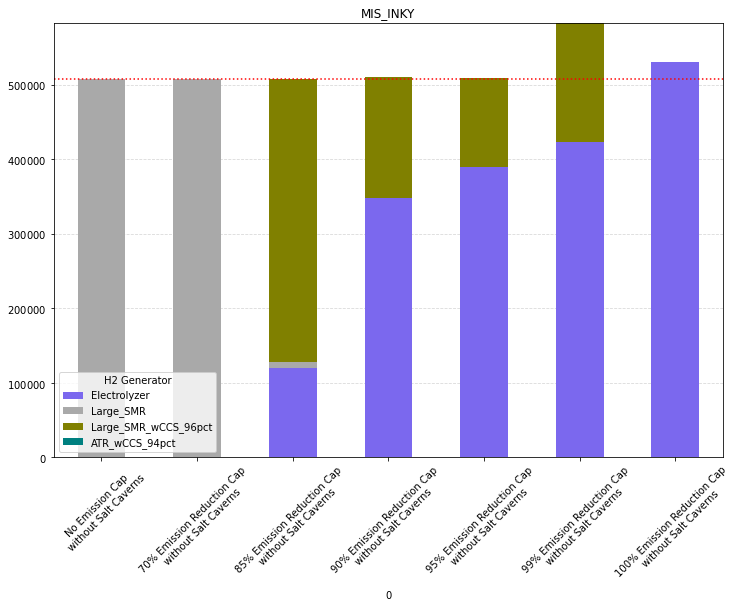

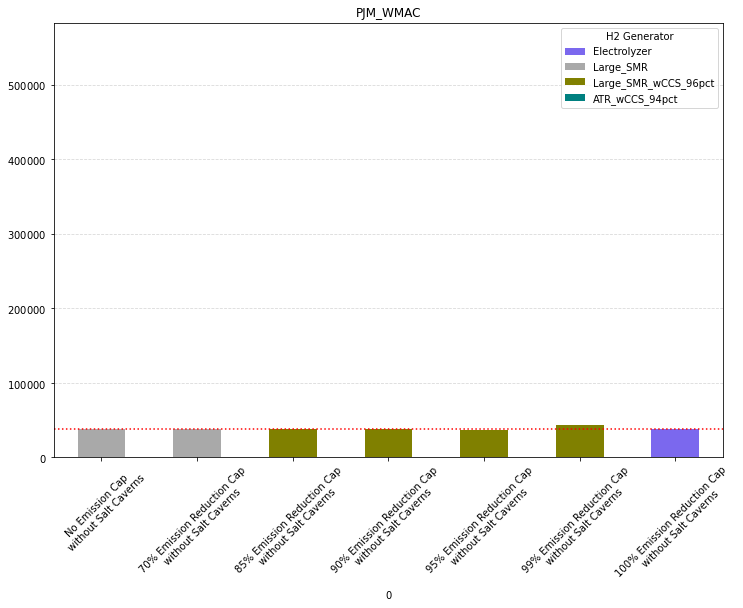

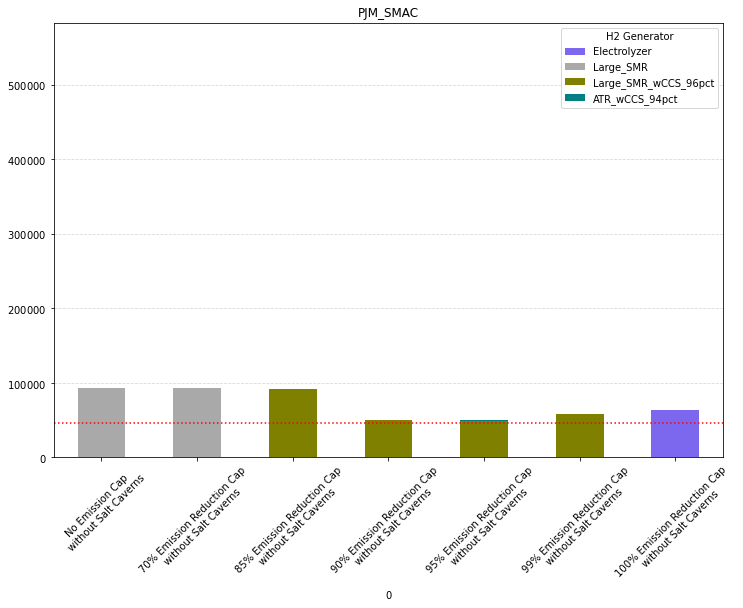

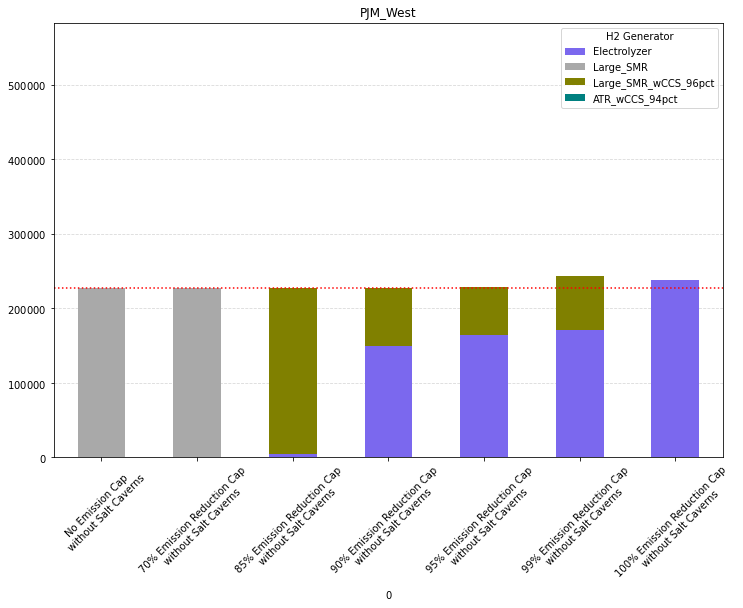

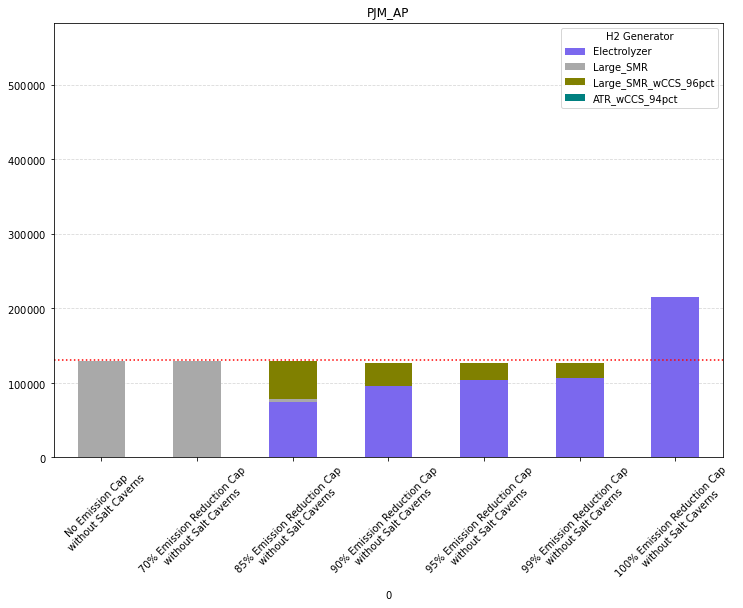

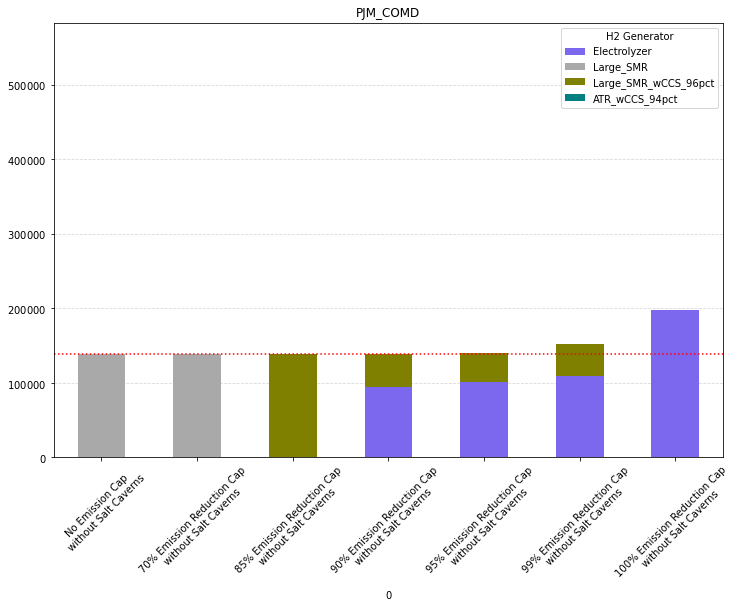

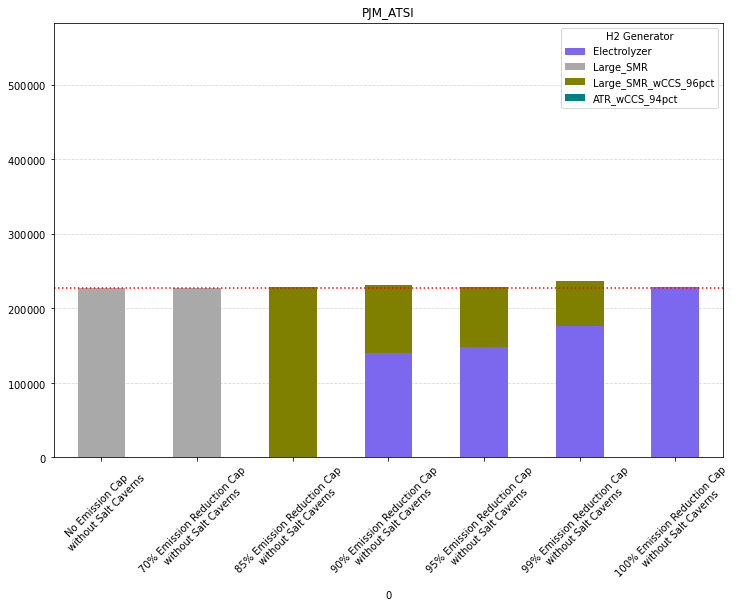

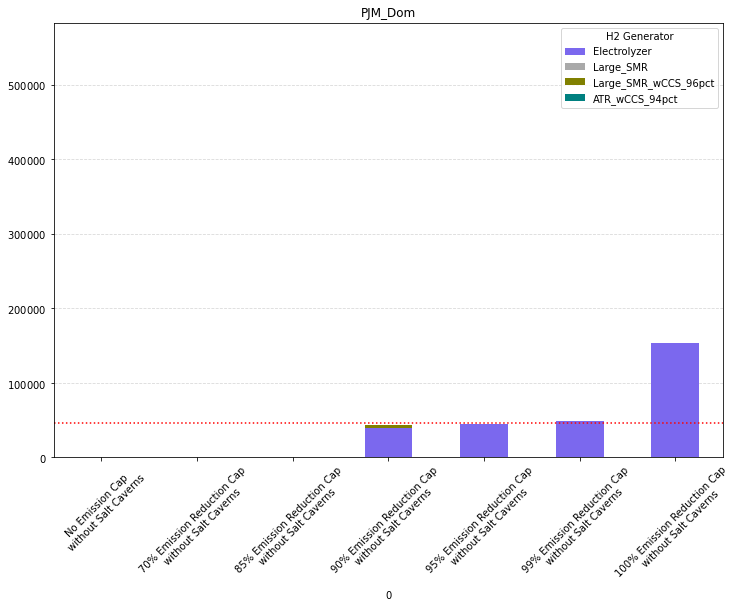

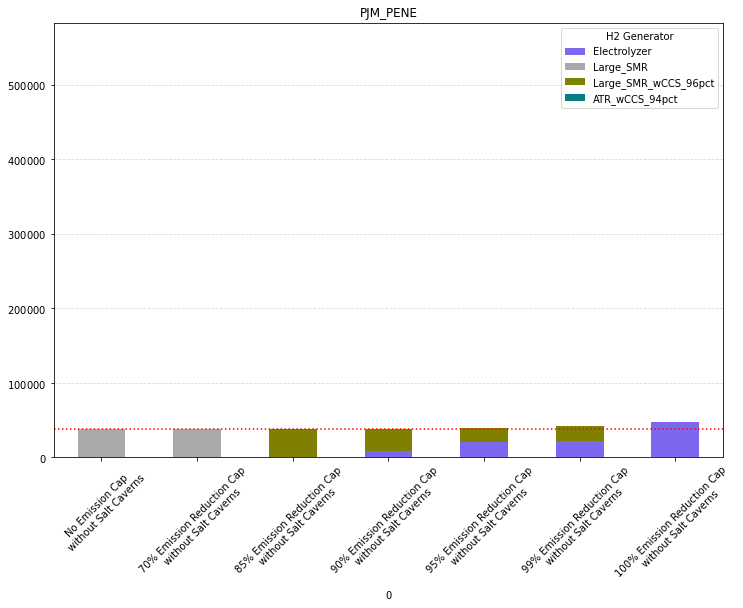

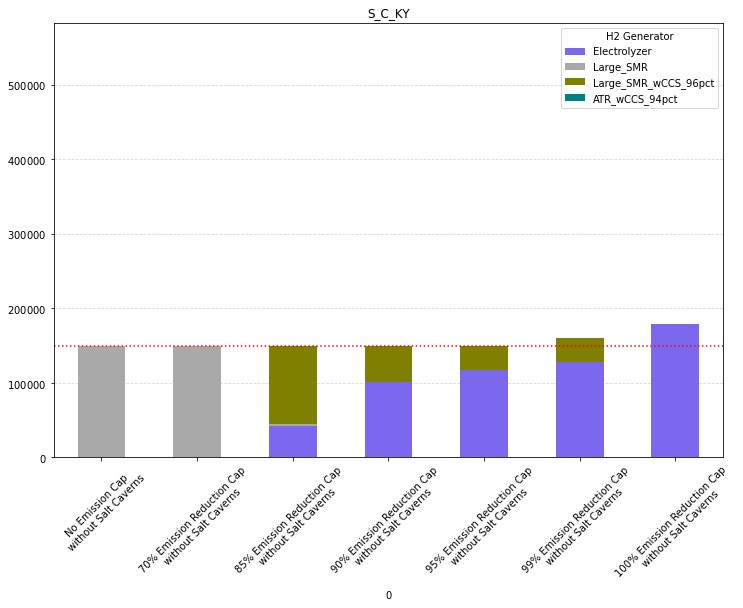

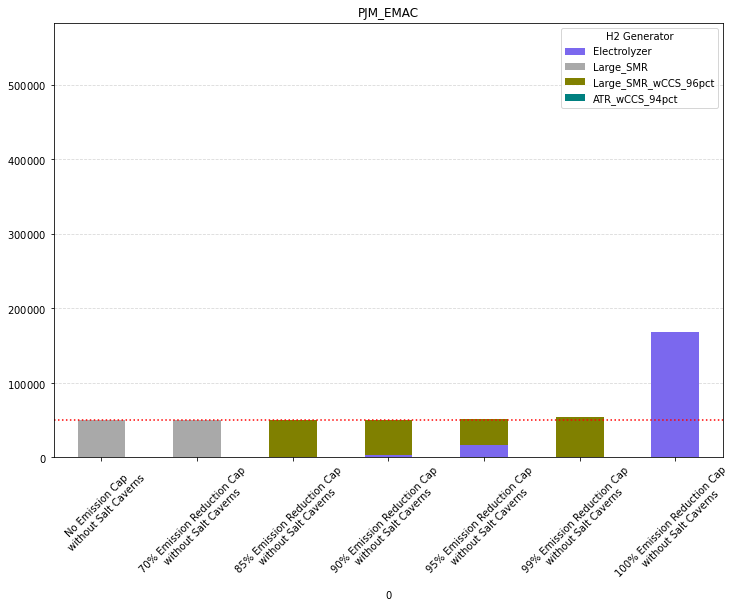

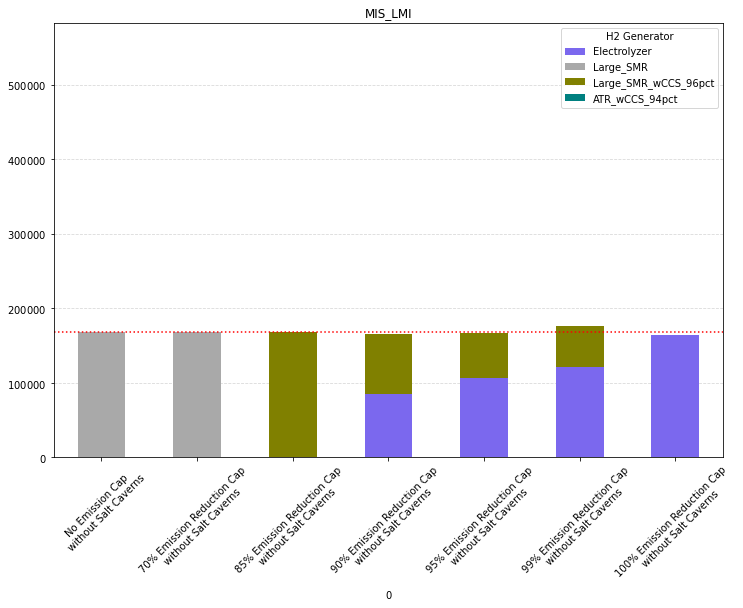

In [37]:
multiple_zone_barchart_plot(dataframes_dict = dataframes_dict, scenarios = scenarios)

## IPM Map Plot

In [38]:
import geopandas as gpd


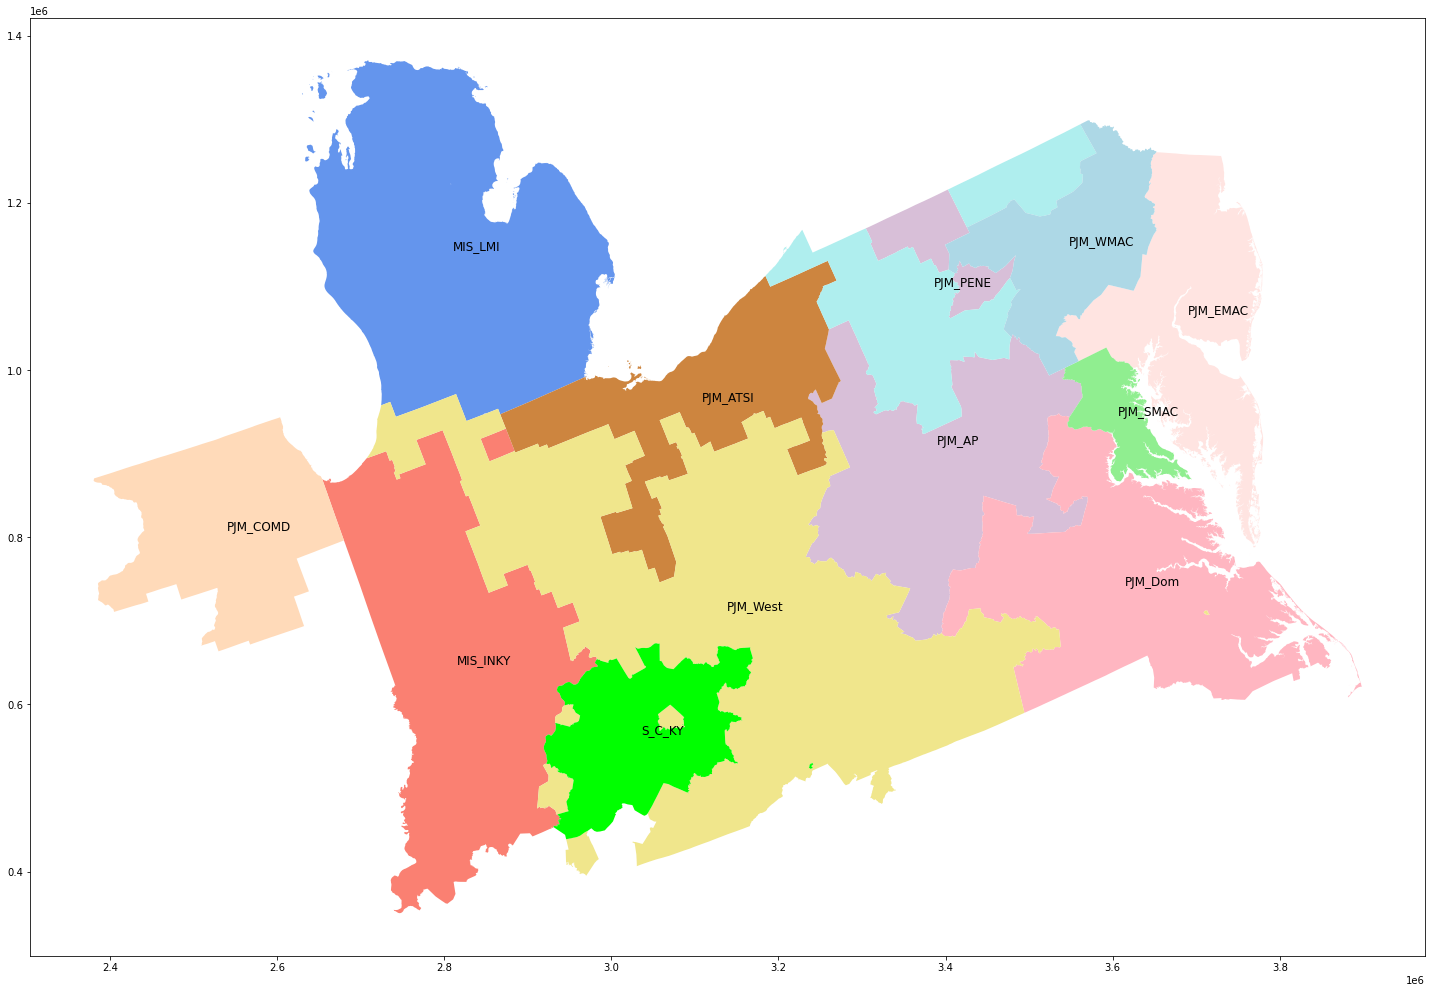

In [39]:
colors_IPM_zones = {
    "MIS_INKY": "salmon",
    "PJM_WMAC": "lightblue",
    "PJM_SMAC": "lightgreen",
    "PJM_West": "khaki",
    "PJM_AP": "thistle",
    "PJM_COMD": "peachpuff",
    "PJM_ATSI": "peru",
    "PJM_Dom": "lightpink",
    "PJM_PENE": "paleturquoise",
    "S_C_KY": "lime",
    "PJM_EMAC": "mistyrose",
    "MIS_LMI": "cornflowerblue"
}


def plot_IPM_zones_filtered(IPM_shapefile_path='ipm_v6_regions', zones=zones, colors=colors_IPM_zones):
    
    gdf = gpd.read_file(IPM_shapefile_path)
    gdf = gdf[gdf['IPM_Region'].isin(zones)]

    # Define color map (you may want to adjust colors according to your preferences)

    # Create a new figure
    fig, ax = plt.subplots(1, 1, figsize=(25, 20)) # Change the size according to your needs

    # Loop over each row in the GeoDataFrame
    for index, row in gdf.iterrows():
        # Plot the zone with the color specified in the color map
        gdf[gdf["IPM_Region"] == row["IPM_Region"]].plot(color=colors_IPM_zones[row["IPM_Region"]], ax=ax)

        # Add a label at the centroid of the zone
        centroid = row["geometry"].centroid
        plt.text(centroid.x, centroid.y, str(row["IPM_Region"]), fontsize=12)

    # Display the plot
    plt.show()
    
plot_IPM_zones_filtered()

# Transmission Analysis

## Electrical Transmission

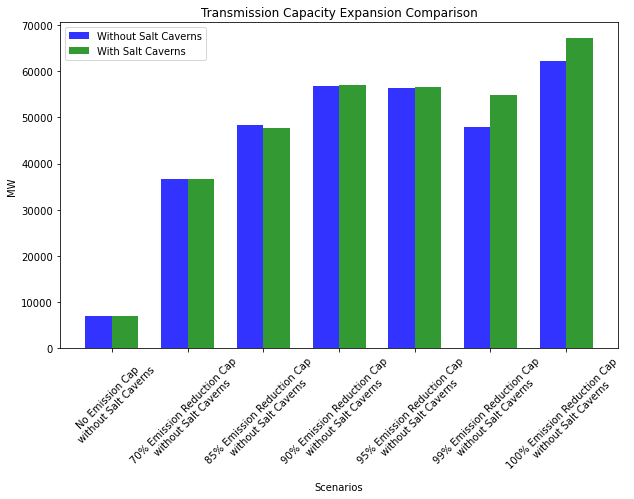

In [40]:
# Without caverns
trans_cap_list_no_caverns = []
for scenario in scenarios_no_caverns:
    df = open_results_file('network_expansion.csv', scenario)
    trans_cap_total = df['New_Trans_Capacity'].sum()
    trans_cap_list_no_caverns.append(trans_cap_total)

# With caverns
trans_cap_list_with_caverns = []
for scenario in scenarios_with_caverns:
    df = open_results_file('network_expansion.csv', scenario)
    trans_cap_total = df['New_Trans_Capacity'].sum()
    trans_cap_list_with_caverns.append(trans_cap_total)
    
# Settings for the bars
bar_width = 0.35
opacity = 0.8

# Rename scenarios
scenarios_renamed = [rename_dict[s] for s in scenarios_no_caverns]

# Create an array with the position of each bar along the x-axis
r1 = np.arange(len(trans_cap_list_no_caverns))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(r1, trans_cap_list_no_caverns, color='blue', width=bar_width, alpha=opacity, label='Without Salt Caverns')
plt.bar(r2, trans_cap_list_with_caverns, color='green', width=bar_width, alpha=opacity, label='With Salt Caverns')

# Add labels, title, legend, etc
plt.xlabel('Scenarios')  
plt.ylabel('MW')
plt.title('Transmission Capacity Expansion Comparison')
plt.xticks([r + bar_width / 2 for r in range(len(trans_cap_list_no_caverns))], scenarios_renamed, rotation=45)
plt.legend()

plt.show()


## H2 Pipeline Transmission

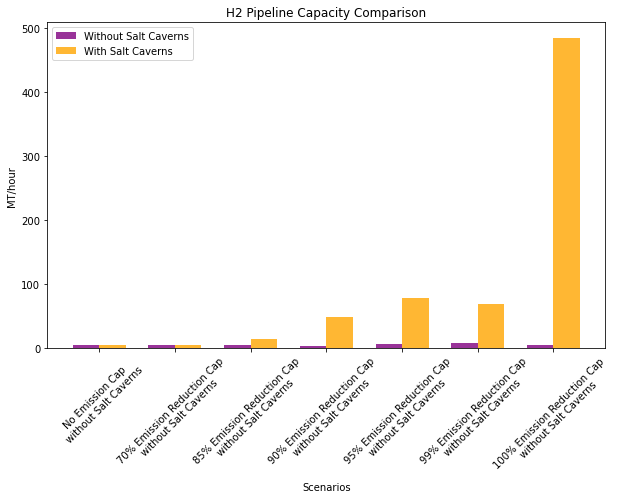

In [41]:

# Without caverns
h2_pipe_cap_list_no_caverns = []
for scenario in scenarios_no_caverns:
    df = open_results_file('HSC_pipeline_expansion.csv', scenario)
    new_h2_pipeline_cap_total = df['New_Trans_Capacity'].sum()
    h2_pipe_cap_list_no_caverns.append(new_h2_pipeline_cap_total)

# With caverns
h2_pipe_cap_list_with_caverns = []
for scenario in scenarios_with_caverns:
    df = open_results_file('HSC_pipeline_expansion.csv', scenario)
    new_h2_pipeline_cap_total = df['New_Trans_Capacity'].sum()
    h2_pipe_cap_list_with_caverns.append(new_h2_pipeline_cap_total)

    
# Settings for the bars
bar_width = 0.35
opacity = 0.8

# Rename scenarios
scenarios_renamed = [rename_dict[s] for s in scenarios_no_caverns]

# Create an array with the position of each bar along the x-axis
r1 = np.arange(len(h2_pipe_cap_list_no_caverns))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(r1, h2_pipe_cap_list_no_caverns, color='purple', width=bar_width, alpha=opacity, label='Without Salt Caverns')
plt.bar(r2, h2_pipe_cap_list_with_caverns, color='orange', width=bar_width, alpha=opacity, label='With Salt Caverns')

# Add labels, title, legend, etc
plt.xlabel('Scenarios')  
plt.ylabel('MT/hour')
plt.title('H2 Pipeline Capacity Comparison')
plt.xticks([r + bar_width / 2 for r in range(len(h2_pipe_cap_list_no_caverns))], scenarios_renamed, rotation=45)
plt.legend()

plt.show()


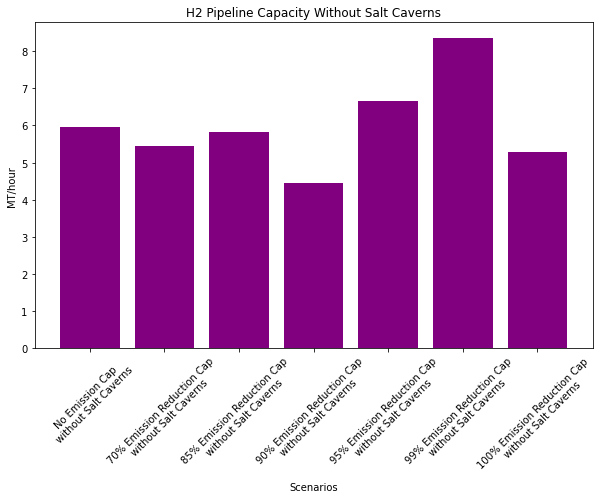

In [42]:
h2_pipe_cap_list = []
for scenario in scenarios_no_caverns:
    df = open_results_file('HSC_pipeline_expansion.csv',scenario )
    new_h2_pipeline_cap_total = df['New_Trans_Capacity'].sum()
    h2_pipe_cap_list.append(new_h2_pipeline_cap_total)

# Rename scenarios
scenarios_renamed = [rename_dict[s] for s in scenarios]

plt.figure(figsize=(10,6))
plt.bar(scenarios_renamed, h2_pipe_cap_list, color='purple')
plt.xlabel('Scenarios')  
plt.ylabel('MT/hour')
plt.title('H2 Pipeline Capacity Without Salt Caverns')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()